https://dacon.io/competitions/official/235670/data


(과정)


피처 생성 -> 전처리(소문자 변환, 이상치 처리, 특수문자 제거) -> 생성한 수치형 피처들끼리 다중공선성 확인 → 다중공선성 너무 높은 칼럼은 제거(10이상은 제거하는 게 좋음) -> text 칼럼 벡터화/임베딩 후 결합(hstack으로?) -> 모델링 -> 정확도 확인

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/test_x.csv')
submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/sample_submission.csv')

-> 이거 ESAA OB 3조 드라이브를 my drive에 바로가기로 지정해놓으면 모두 같은 경로로 통일할 수 있어요..!

In [ ]:
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


### 0. EDA 코드

<Axes: >

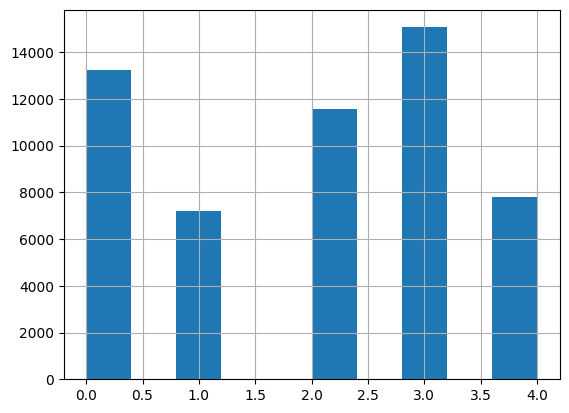

In [ ]:
train['author'].hist()

In [ ]:
train['author'].value_counts()

,count
author,
3,15063
0,13235
2,11554
4,7805
1,7222


- 이상치 없음 → 모든 작가는 7000개 이상 샘플을 가지고 있어서 학습에는 충분함

- author 값도 0~4 사이 정수로 잘 구성되어 있음

=> 따라서, author 컬럼 기준 이상치 제거는 필요 없음

In [ ]:
train["text_length"] = train["text"].str.len()
test["text_length"] = test["text"].str.len()

print(train["text_length"].describe())

count    54879.000000
mean       228.115563
std        276.293793
min          9.000000
25%         63.000000
50%        118.000000
75%        265.000000
max       2500.000000
Name: text_length, dtype: float64


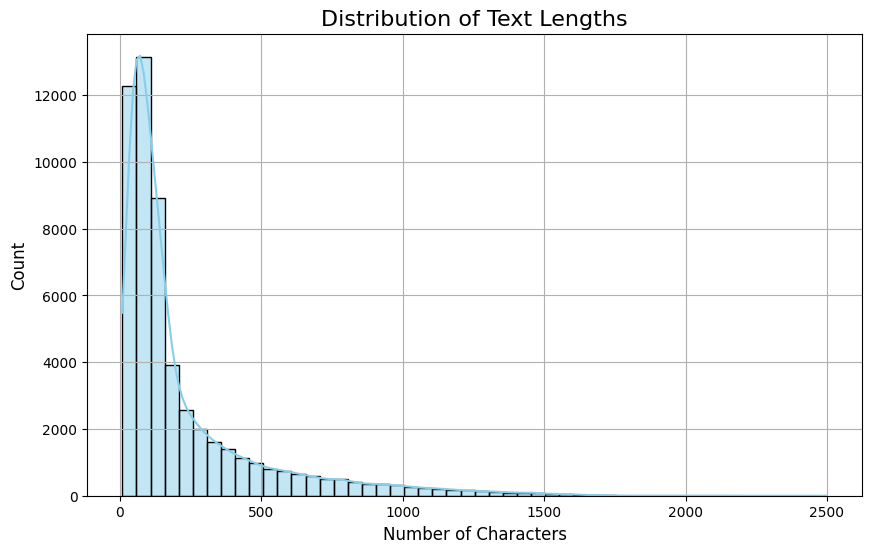

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train["text_length"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Text Lengths", fontsize=16)
plt.xlabel("Number of Characters", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True)
plt.show()

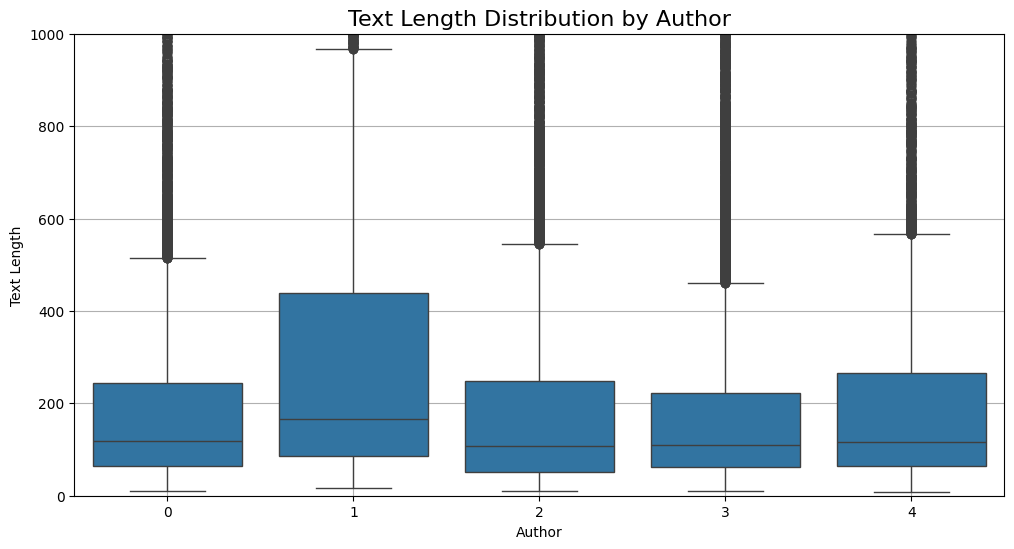

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="author", y="text_length", data=train)
plt.title("Text Length Distribution by Author", fontsize=16)
plt.xlabel("Author")
plt.ylabel("Text Length")
plt.ylim(0, 1000)  # 너무 긴 값은 잘라서 보기 좋게
plt.grid(True)
plt.show()

### 2. 피처 생성

In [ ]:
!pip install textstat

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk import word_tokenize, pos_tag, ne_chunk, tree2conlltags
import string
from textstat import flesch_reading_ease # 읽기 난이도 점수

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

eng_stopwords = set(stopwords.words("english"))
symbols_knowns = string.ascii_letters + string.digits + string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data

In [ ]:
def sentiment_nltk(text): # 감성 점수
    res = SentimentIntensityAnalyzer().polarity_scores(text)
    return res['compound']

def get_words(text): # 구두점 제거 후 단어만 추출
    words = nltk.tokenize.word_tokenize(text)
    return [word for word in words if not word in string.punctuation]

def count_tokens(text, tokens): # 특정 토큰의 빈도수 카운트
    return sum([w in tokens for w in get_words(text)])

def first_word_len(text): # 텍스트의 첫 단어 길이
    if(len(get_words(text))==0):
        return 0
    else:
        return len(get_words(text)[0])

def last_word_len(text): # 텍스트의 마지막 단어 길이
    if(len(get_words(text))==0):
        return 0
    else:
        return len(get_words(text)[-1])

def symbol_aid(x): # 알파벳, 숫자, 기호들 중 x의 인덱스 반환
    symbols=[x for x in symbols_knowns]

    if x not in symbols:
        return -1
    else:
        return np.where(np.array(symbols) == x )[0][0]

In [ ]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

def fraction_noun(text): # 명사 비율을 POS 태깅 기반으로 계산
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    if word_count==0:
        return 0
    else:
        pos_list = nltk.pos_tag(text_splited)
        noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])

        return (noun_count/word_count)

def fraction_adj(text): # 형용사 비율을 POS 태깅 기반으로 계산
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    if word_count==0:
        return 0
    else:
        pos_list = nltk.pos_tag(text_splited)
        adj_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])

        return (adj_count/word_count)

def fraction_verbs(text): # 동사 비율을 POS 태깅 기반으로 계산
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    if word_count==0:
        return 0
    else:
        pos_list = nltk.pos_tag(text_splited)
        verbs_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])

        return (verbs_count/word_count)


from collections import Counter

def repetition_score(text):
    words = text.lower().split()
    counts = Counter(words)
    return sum([v for v in counts.values() if v > 1]) / len(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train['num_words']=train['text'].apply(lambda x:len(get_words(x))) # 단어 수
train['mean_word_len']=train['text'].apply(lambda x:np.mean([len(w) for w in str(x).split()])) # 평균 단어 길이
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split()))) # 고유 단어 수
train["num_chars"] = train["text"].apply(lambda x: len(str(x))) # 문자 수
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords])) # 불용어 개수
train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) ) # 구두점 개수
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))/train["num_words"] # 대문자 단어 비율
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))/train["num_words"] # 제목 스타일 단어 비율
train["chars_between_comma"] = train["text"].apply(lambda x: np.mean([len(chunk) for chunk in str(x).split(",")]))/train["num_chars"] # 쉼표로 나눈 조각의 평균 길이
train["symbols_unknowns"]=train["text"].apply(lambda x: np.sum([not w in symbols_knowns for w in str(x)]))/train["num_chars"] # 알 수 없는 기호 비율
train['noun'] = train["text"].apply(lambda x: fraction_noun(x)) # 명사 비율
train['adj'] = train["text"].apply(lambda x: fraction_adj(x)) # 형용사 비율
train['verbs'] = train["text"].apply(lambda x: fraction_verbs(x)) # 동사 비율
train["sentiment"]=train["text"].apply(sentiment_nltk) # 감성 점수 (VADER)
train['single_frac'] = train['text'].apply(lambda x: count_tokens(x, ['is', 'was', 'has', 'he', 'she', 'it', 'her', 'his']))/train["num_words"] # 단수형 비율
train['plural_frac'] = train['text'].apply(lambda x: count_tokens(x, ['are', 'were', 'have', 'we', 'they']))/train["num_words"] # 복수형 비율
train['first_word_len']=train['text'].apply(first_word_len)/train["num_chars"] # 처음 단어 길이
train['last_word_len']=train['text'].apply(last_word_len)/train["num_chars"] # 끝 단어 길이
train["first_word_id"] = train['text'].apply(lambda x: symbol_aid(list(x.strip())[0])) # 처음 단어 인덱스
train["last_word_id"] = train['text'].apply(lambda x: symbol_aid(list(x.strip())[-1])) # 끝 단어 인덱스
train['ease']=train['text'].apply(flesch_reading_ease) # 읽기 쉬움 점수


test['num_words']=test['text'].apply(lambda x:len(str(x).split()))
test['mean_word_len']=test['text'].apply(lambda x:np.mean([len(w) for w in str(x).split()]))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))/test["num_words"]
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))/test["num_words"]
test["chars_between_comma"] = test["text"].apply(lambda x: np.mean([len(chunk) for chunk in str(x).split(",")]))/test["num_chars"]
test["symbols_unknowns"]=test["text"].apply(lambda x: np.sum([not w in symbols_knowns for w in str(x)]))/test["num_chars"]
test['noun'] = test["text"].apply(lambda x: fraction_noun(x))
test['adj'] = test["text"].apply(lambda x: fraction_adj(x))
test['verbs'] = test["text"].apply(lambda x: fraction_verbs(x))
test["sentiment"]=test["text"].apply(sentiment_nltk)
test['single_frac'] = test['text'].apply(lambda x: count_tokens(x, ['is', 'was', 'has', 'he', 'she', 'it', 'her', 'his']))/test["num_words"]
test['plural_frac'] = test['text'].apply(lambda x: count_tokens(x, ['are', 'were', 'have', 'we', 'they']))/test["num_words"]
test['first_word_len']=test['text'].apply(first_word_len)/test["num_chars"]
test['last_word_len']=test['text'].apply(last_word_len)/test["num_chars"]
test["first_word_id"] = test['text'].apply(lambda x: symbol_aid(list(x.strip())[0]))
test["last_word_id"] = test['text'].apply(lambda x: symbol_aid(list(x.strip())[-1]))
test['ease']=test['text'].apply(flesch_reading_ease)

In [ ]:
# 쉼표 개수
train["num_commas"] = train["text"].apply(lambda x: x.count(","))
test["num_commas"] = test["text"].apply(lambda x: x.count(","))

# 특정 단어 등장 횟수
train["count_The"] = train["text"].apply(lambda x: x.count("The "))
test["count_The"] = test["text"].apply(lambda x: x.count("The "))

# 느낌표 수
train["count_exclam"] = train["text"].apply(lambda x: x.count("!"))
test["count_exclam"] = test["text"].apply(lambda x: x.count("!"))

# 문장 길이 관련 피쳐
# 문장 수, 평균 문장 길이 (문장 구조나 흐름의 복잡도 파악 가능)
train["num_sentences"] = train["text"].apply(lambda x: len(sent_tokenize(x)))
train["mean_sentence_len"] = train["text"].apply(lambda x: np.mean([len(s.split()) for s in sent_tokenize(x)]))

test["num_sentences"] = test["text"].apply(lambda x: len(sent_tokenize(x)))
test["mean_sentence_len"] = test["text"].apply(lambda x: np.mean([len(s.split()) for s in sent_tokenize(x)]))

# 어휘 다양성 비율 (Type-Token Ration)
train["ttr"] = train["num_unique_words"] / train["num_words"]
test["ttr"] = test["num_unique_words"] / test["num_words"]

# 어휘 수준 (텍스트의 난이도 또는 단어의 길이/빈도 기반) - 고급 어휘인지 여부
from nltk.corpus import words
nltk.download('words')
english_vocab = set(words.words())

train["rare_word_count"] = train["text"].apply(lambda x: sum(1 for w in x.split() if w.lower() not in english_vocab))
train["rare_word_ratio"] = train["rare_word_count"] / train["num_words"]

test["rare_word_count"] = test["text"].apply(lambda x: sum(1 for w in x.split() if w.lower() not in english_vocab))
test["rare_word_ratio"] = test["rare_word_count"] / test["num_words"]

# 동일 단어 반복률
train["repetition_rate"] = train["text"].apply(repetition_score)
test["repetition_rate"] = test["text"].apply(repetition_score)

# 질문 사용 여부
train["num_questions"] = train["text"].apply(lambda x: x.count("?"))
test["num_questions"] = test["text"].apply(lambda x: x.count("?"))

# 인용 부호 사용
train["num_quotes"] = train["text"].apply(lambda x: x.count('"') + x.count("'"))
test["num_quotes"] = test["text"].apply(lambda x: x.count('"') + x.count("'"))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


- 축약형 함수

In [ ]:
# contraction dict
contractions = {
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I shall / I will",
    "I'll've": "I shall have / I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have"
}

# 소문자 기반으로 축약형 리스트 준비
contraction_list = list(contractions.keys())
contraction_pattern = re.compile(r'\b(' + '|'.join(re.escape(c) for c in contraction_list) + r')\b', flags=re.IGNORECASE)

# 축약형 개수 세는 함수
def count_contractions(text):
    return len(contraction_pattern.findall(text.lower()))

# 각 row에 적용
train['contraction_count'] = train['text'].apply(count_contractions)

test['contraction_count'] = test['text'].apply(count_contractions)

### 전처리


#### (0) 이상치 제거

In [ ]:
# 이상치 확인
train['length'] = train['text'].map(len)
test['length'] = test['text'].map(len)
train[train['length'] <= 12]

,index,text,author,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,...,num_sentences,mean_sentence_len,ttr,rare_word_count,rare_word_ratio,repetition_rate,num_questions,num_quotes,contraction_count,length
1455,1455,* * * * *,2,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
3493,3493,* * * * *,4,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
5523,5523,* * * * *,4,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
5985,5985,* * * * *,4,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
8400,8400,* * * * *,2,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
9874,9874,* * * * *,3,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
12267,12267,* * * * *,2,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
12460,12460,* * * * *,4,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
13055,13055,* * * * *,4,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10
14698,14698,* * * * *,4,10,0,1.0,1,10,0,5,...,1,5.0,inf,5,inf,1.0,0,0,0,10


In [ ]:
# '*****' 제거
train = train[train['length'] > 12]
test = test[test['length'] > 12]

In [ ]:
# 중복 텍스트 제거
train = train.drop_duplicates(subset='text')
test = test.drop_duplicates(subset='text')

특수문자가 절반 이상인 텍스트를 제거하는 코드

In [ ]:
import re

def is_mostly_special(text):
    text = str(text).strip()
    if len(text) == 0:
        return True  # 빈 문자열도 제거 대상
    return len(re.sub(r'[A-Za-z0-9가-힣]', '', text)) / len(text) > 0.5

# 특수문자가 절반 이상인 텍스트를 제거한 train 데이터프레임 생성
train = train[~train['text'].map(is_mostly_special)].reset_index(drop=True)
test = test[~test['text'].map(is_mostly_special)].reset_index(drop=True)

- 대문자를 다 소문자로 변환하는 코드

In [ ]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

#### (1) 띄어쓰기, 토큰화

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# 토큰화 함수 정의
def tokenize_text(text):
    return word_tokenize(text)

# train 데이터에 적용
train['tokens'] = train['text'].apply(tokenize_text)
test['tokens'] = test['text'].apply(tokenize_text)

#### (2) 불용어, 어간 추출

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# 1) 불용어 리스트와 스테머 준비
eng_stopwords = {
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"}
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# 전처리 함수:
# 토큰화 → 불용어 제거 → 스테밍
def preprocess(tokens: list[str]):
    # (b) 불용어 제거
    filtered = [w for w in tokens if w.isalpha() and w not in eng_stopwords]
    # (c) 어간 추출
    stems = [stemmer.stem(w) for w in filtered]
    return stems, filtered


# 전처리(불용어 제거 + 스테밍) 적용
# preprocess()가 (stems, filtered_stopwords_removed_tokens)를 리턴하므로 unpack
train[["stems", "_filtered_tokens"]] = train["tokens"].apply(
    lambda toks: pd.Series(preprocess(toks), index=["stems", "_filtered_tokens"])
)
test[["stems", "_filtered_tokens"]] = test["tokens"].apply(
    lambda toks: pd.Series(preprocess(toks), index=["stems", "_filtered_tokens"])
)

# 통계 컬럼 계산
# 어간 개수
train["num_stems"] = train["stems"].apply(len)
test["num_stems"] = test["stems"].apply(len)

# 불용어 개수: 원 토큰 중 stopword였던 개수
train["num_stopwords"] = train["tokens"].apply(
    lambda toks: sum(1 for w in toks if w.isalpha() and w in eng_stopwords)
)
test["num_stopwords"] = test["tokens"].apply(
    lambda toks: sum(1 for w in toks if w.isalpha() and w in eng_stopwords)
)

# 전체 토큰 개수 (알파벳 단어 기준)
train["num_tokens"] = train["tokens"].apply(lambda toks: sum(1 for w in toks if w.isalpha()))
test["num_tokens"] = test["tokens"].apply(lambda toks: sum(1 for w in toks if w.isalpha()))

# 불용어 비율
train["stopword_ratio"] = train["num_stopwords"] / train["num_tokens"]
test["stopword_ratio"] = test["num_stopwords"] / test["num_tokens"]

# 8) 결과 확인
print(train[[
    "author", "num_stems", "num_stopwords", "num_tokens", "stopword_ratio"
]].head())

   author  num_stems  num_stopwords  num_tokens  stopword_ratio
0       3         17             29          46        0.630435
1       2          3              4           7        0.571429
2       1         27             30          57        0.526316
3       4         26             31          57        0.543860
4       3         20             21          41        0.512195


In [ ]:
print(test[["num_stems", "num_stopwords", "num_tokens", "stopword_ratio"]].head())

   num_stems  num_stopwords  num_tokens  stopword_ratio
0         32             57          89        0.640449
1         10             36          46        0.782609
2         28             35          63        0.555556
3         92            148         240        0.616667
4         35             58          93        0.623656


#### (3) 형태소 분석기

In [ ]:
grouped_df = train.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  0
'you were not here last sunday night,' he said.
i had scant luggage to take with me to london, for little of the little i possessed was adapted to my new station. but i began packing that same afternoon, and wildly packed up things that i knew i should want next morning, in a fiction that there was not a moment to be lost.
‘why, the fact is,’ returned odin, ‘mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. a most remarkable circumstance is, that i really don’t think he grasped this sum even so much for the gratification of his avarice, which was inordinate, as in the hatred he felt for odin. he said so to me, plainly. he said he would even have spent as much, to baulk or injure odin.’
dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and i had made up my mind that it should not be there. if there must be suc

- Stemming

In [ ]:
from nltk.stem import PorterStemmer

# be 동사만 일단 불용어로 지정해봄
be_forms = {'am', 'is', 'are', 'was', 'were', 'be', 'being', 'been'}

stemmer = PorterStemmer()

train['stemmed_tokens'] = train['_filtered_tokens'].apply(
    lambda tokens: [stemmer.stem(token) for token in tokens if token.lower() not in be_forms])

test['stemmed_tokens'] = test['_filtered_tokens'].apply(
    lambda tokens: [stemmer.stem(token) for token in tokens if token.lower() not in be_forms])

In [ ]:
# stemmed_tokens에서 공백이나 빈 문자열 제거
train['stemmed_tokens'] = train['stemmed_tokens'].apply(
    lambda tokens: [token for token in tokens if token.strip() != ''])

test['stemmed_tokens'] = test['stemmed_tokens'].apply(
    lambda tokens: [token for token in tokens if token.strip() != ''])

In [ ]:
train.head()

,index,text,author,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,...,num_quotes,contraction_count,length,tokens,stems,_filtered_tokens,num_stems,num_tokens,stopword_ratio,stemmed_tokens
0,0,"he was almost choking. there was so much, so m...",3,240,46,4.239130,39,240,29,8,...,0,0,240,"[he, was, almost, choking, ., there, was, so, ...","[choke, want, say, strang, exclam, came, lip, ...","[choking, wanted, say, strange, exclamations, ...",17,46,0.630435,"[choke, want, say, strang, exclam, came, lip, ..."
1,1,"“your sister asked for it, i suppose?”",2,38,9,4.571429,7,38,4,2,...,0,0,38,"[“, your, sister, asked, for, it, ,, i, suppos...","[sister, ask, suppos]","[sister, asked, suppose]",3,7,0.571429,"[sister, ask, suppos]"
2,2,"she was engaged one day as she walked, in per...",1,320,59,4.614035,50,320,30,9,...,0,0,320,"[she, was, engaged, one, day, as, she, walked,...","[engag, day, walk, perus, jane, s, letter, dwe...","[engaged, day, walked, perusing, jane, s, lett...",27,57,0.526316,"[engag, day, walk, perus, jane, s, letter, dwe..."
3,3,"the captain was in the porch, keeping himself ...",4,319,61,4.517241,49,319,31,18,...,1,0,319,"[the, captain, was, in, the, porch, ,, keeping...","[captain, porch, keep, care, way, treacher, sh...","[captain, porch, keeping, carefully, way, trea...",26,57,0.543860,"[captain, porch, keep, care, way, treacher, sh..."
4,4,"“have mercy, gentlemen!” odin flung up his han...",3,228,48,4.871795,36,228,21,13,...,0,0,228,"[“, have, mercy, ,, gentlemen, !, ”, odin, flu...","[merci, gentlemen, odin, flung, hand, don, t, ...","[mercy, gentlemen, odin, flung, hands, don, t,...",20,41,0.512195,"[merci, gentlemen, odin, flung, hand, don, t, ..."


In [ ]:
grouped_df = train.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["stemmed_tokens"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  0
['sunday', 'night', 'said']
['scant', 'luggag', 'london', 'littl', 'littl', 'possess', 'adapt', 'new', 'station', 'began', 'pack', 'afternoon', 'wildli', 'pack', 'thing', 'knew', 'want', 'morn', 'fiction', 'moment', 'lost']
['fact', 'return', 'odin', 'mr', 'odin', 'complet', 'hem', 'readi', 'new', 'point', 'old', 'fail', 'escap', 'remark', 'circumst', 'realli', 'don', 't', 'think', 'grasp', 'sum', 'gratif', 'avaric', 'inordin', 'hatr', 'felt', 'odin', 'said', 'plainli', 'said', 'spent', 'baulk', 'injur', 'odin']
['dora', 'delight', 'littl', 'present', 'kiss', 'joy', 'shadow', 'slight', 'mind', 'shadow', 'futur', 'breast']
['kind', 'tone', 'answer', 'sweet', 'voic', 'gentl', 'manner', 'absenc', 'accent', 'haughti', 'displeasur', 'took', 'girl', 'complet', 'surpris', 'burst', 'tear']


Author name :  1
['engag', 'day', 'walk', 'perus', 'jane', 's', 'letter', 'dwell', 'passag', 'prove', 'jane', 'written', 'spirit', 'instead', 'surpris', 'odin', 'saw', 'look', 'odin', 'mee

- Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

# be 동사 목록
be_forms = {'am', 'is', 'are', 'was', 'were', 'be', 'being', 'been'}

lemmatizer = WordNetLemmatizer()

train['lemmatized_tokens'] = train['_filtered_tokens'].apply(
    lambda tokens: [lemmatizer.lemmatize(token, pos='v') for token in tokens if token.lower() not in be_forms])

test['lemmatized_tokens'] = test['_filtered_tokens'].apply(
    lambda tokens: [lemmatizer.lemmatize(token, pos='v') for token in tokens if token.lower() not in be_forms])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
train.head()

,index,text,author,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,...,contraction_count,length,tokens,stems,_filtered_tokens,num_stems,num_tokens,stopword_ratio,stemmed_tokens,lemmatized_tokens
0,0,"he was almost choking. there was so much, so m...",3,240,46,4.239130,39,240,29,8,...,0,240,"[he, was, almost, choking, ., there, was, so, ...","[choke, want, say, strang, exclam, came, lip, ...","[choking, wanted, say, strange, exclamations, ...",17,46,0.630435,"[choke, want, say, strang, exclam, came, lip, ...","[choke, want, say, strange, exclamations, come..."
1,1,"“your sister asked for it, i suppose?”",2,38,9,4.571429,7,38,4,2,...,0,38,"[“, your, sister, asked, for, it, ,, i, suppos...","[sister, ask, suppos]","[sister, asked, suppose]",3,7,0.571429,"[sister, ask, suppos]","[sister, ask, suppose]"
2,2,"she was engaged one day as she walked, in per...",1,320,59,4.614035,50,320,30,9,...,0,320,"[she, was, engaged, one, day, as, she, walked,...","[engag, day, walk, perus, jane, s, letter, dwe...","[engaged, day, walked, perusing, jane, s, lett...",27,57,0.526316,"[engag, day, walk, perus, jane, s, letter, dwe...","[engage, day, walk, peruse, jane, s, letter, d..."
3,3,"the captain was in the porch, keeping himself ...",4,319,61,4.517241,49,319,31,18,...,0,319,"[the, captain, was, in, the, porch, ,, keeping...","[captain, porch, keep, care, way, treacher, sh...","[captain, porch, keeping, carefully, way, trea...",26,57,0.543860,"[captain, porch, keep, care, way, treacher, sh...","[captain, porch, keep, carefully, way, treache..."
4,4,"“have mercy, gentlemen!” odin flung up his han...",3,228,48,4.871795,36,228,21,13,...,0,228,"[“, have, mercy, ,, gentlemen, !, ”, odin, flu...","[merci, gentlemen, odin, flung, hand, don, t, ...","[mercy, gentlemen, odin, flung, hands, don, t,...",20,41,0.512195,"[merci, gentlemen, odin, flung, hand, don, t, ...","[mercy, gentlemen, odin, fling, hand, don, t, ..."


In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk

# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

# be 동사 목록
be_forms = {'am', 'is', 'are', 'was', 'were', 'be', 'being', 'been'}

# 품사 태그를 WordNet POS 태그로 매핑하는 함수
def pos_tag_to_wordnet(tag):
    if tag.startswith('VB'):
        return 'v'  # 동사
    elif tag.startswith('NN'):
        return 'n'  # 명사
    elif tag.startswith('JJ'):
        return 'a'  # 형용사
    else:
        return None

lemmatizer = WordNetLemmatizer()

# 품사 태깅 후 Lemmatization 적용
def lemmatize_with_pos(tokens):
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        # be 동사 제외
        if token.lower() not in be_forms:
            wordnet_pos = pos_tag_to_wordnet(tag)  # POS 태그 매핑
            if wordnet_pos:  # 매핑된 품사가 있으면
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=wordnet_pos))
            else:
                lemmatized_tokens.append(token)  # 품사가 없으면 원형 그대로
    return lemmatized_tokens

train['lemmatized_tokens'] = train['_filtered_tokens'].apply(lemmatize_with_pos)

In [ ]:
test['lemmatized_tokens'] = test['_filtered_tokens'].apply(lemmatize_with_pos)

In [ ]:
grouped_df = train.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["lemmatized_tokens"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  0
['sunday', 'night', 'say']
['scant', 'luggage', 'london', 'little', 'little', 'possess', 'adapt', 'new', 'station', 'begin', 'pack', 'afternoon', 'wildly', 'pack', 'thing', 'know', 'want', 'morning', 'fiction', 'moment', 'lose']
['fact', 'return', 'odin', 'mr', 'odin', 'completely', 'hem', 'ready', 'new', 'point', 'old', 'fail', 'escape', 'remarkable', 'circumstance', 'really', 'don', 't', 'think', 'grasp', 'sum', 'gratification', 'avarice', 'inordinate', 'hatred', 'felt', 'odin', 'say', 'plainly', 'say', 'spent', 'baulk', 'injure', 'odin']
['dora', 'delight', 'little', 'present', 'kiss', 'joyfully', 'shadow', 'slight', 'mind', 'shadow', 'future', 'breast']
['kind', 'tone', 'answer', 'sweet', 'voice', 'gentle', 'manner', 'absence', 'accent', 'haughtiness', 'displeasure', 'take', 'girl', 'completely', 'surprise', 'burst', 'tear']


Author name :  1
['engage', 'day', 'walk', 'peruse', 'jane', 's', 'letter', 'dwell', 'passage', 'prove', 'jane', 'write', 'spirit', 'instead

#### (+) 전처리된 데이터 CSV로 저장

In [ ]:
# CSV로 저장
train.to_csv('train_cleaned.csv', index=False)
test.to_csv('test_cleaned.csv', index=False)

In [ ]:
import os

save_dir = '/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/'
os.makedirs(save_dir, exist_ok=True)

train.to_csv(os.path.join(save_dir, 'train_cleaned.csv'), index=False, encoding='utf-8-sig')
test.to_csv(os.path.join(save_dir, 'test_cleaned.csv'),  index=False, encoding='utf-8-sig')

### 피처 스케일링

In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/train_cleaned.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/test_cleaned.csv')

In [ ]:
train.head()

,index,text,author,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,...,contraction_count,length,tokens,stems,_filtered_tokens,num_stems,num_tokens,stopword_ratio,stemmed_tokens,lemmatized_tokens
0,0,"he was almost choking. there was so much, so m...",3,240,46,4.239130,39,240,29,8,...,0,240,"['he', 'was', 'almost', 'choking', '.', 'there...","['choke', 'want', 'say', 'strang', 'exclam', '...","['choking', 'wanted', 'say', 'strange', 'excla...",17,46,0.630435,"['choke', 'want', 'say', 'strang', 'exclam', '...","['choke', 'want', 'say', 'strange', 'exclamati..."
1,1,"“your sister asked for it, i suppose?”",2,38,9,4.571429,7,38,4,2,...,0,38,"['“', 'your', 'sister', 'asked', 'for', 'it', ...","['sister', 'ask', 'suppos']","['sister', 'asked', 'suppose']",3,7,0.571429,"['sister', 'ask', 'suppos']","['sister', 'ask', 'suppose']"
2,2,"she was engaged one day as she walked, in per...",1,320,59,4.614035,50,320,30,9,...,0,320,"['she', 'was', 'engaged', 'one', 'day', 'as', ...","['engag', 'day', 'walk', 'perus', 'jane', 's',...","['engaged', 'day', 'walked', 'perusing', 'jane...",27,57,0.526316,"['engag', 'day', 'walk', 'perus', 'jane', 's',...","['engage', 'day', 'walk', 'peruse', 'jane', 's..."
3,3,"the captain was in the porch, keeping himself ...",4,319,61,4.517241,49,319,31,18,...,0,319,"['the', 'captain', 'was', 'in', 'the', 'porch'...","['captain', 'porch', 'keep', 'care', 'way', 't...","['captain', 'porch', 'keeping', 'carefully', '...",26,57,0.543860,"['captain', 'porch', 'keep', 'care', 'way', 't...","['captain', 'porch', 'keep', 'carefully', 'way..."
4,4,"“have mercy, gentlemen!” odin flung up his han...",3,228,48,4.871795,36,228,21,13,...,0,228,"['“', 'have', 'mercy', ',', 'gentlemen', '!', ...","['merci', 'gentlemen', 'odin', 'flung', 'hand'...","['mercy', 'gentlemen', 'odin', 'flung', 'hands...",20,41,0.512195,"['merci', 'gentlemen', 'odin', 'flung', 'hand'...","['mercy', 'gentleman', 'odin', 'flung', 'hand'..."


In [ ]:
test.head()

,index,text,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,...,contraction_count,length,tokens,stems,_filtered_tokens,num_stems,num_tokens,stopword_ratio,stemmed_tokens,lemmatized_tokens
0,0,“not at all. i think she is one of the most ch...,456,89,4.134831,68,456,57,9,0.056180,...,0,456,"['“', 'not', 'at', 'all', '.', 'i', 'think', '...","['think', 'charm', 'young', 'ladi', 'met', 'us...","['think', 'charming', 'young', 'ladies', 'met'...",32,89,0.640449,"['think', 'charm', 'young', 'ladi', 'met', 'us...","['think', 'charm', 'young', 'lady', 'meet', 'u..."
1,1,"""no,"" replied he, with sudden consciousness, ""...",221,43,4.162791,36,221,36,20,0.116279,...,0,221,"['``', 'no', ',', ""''"", 'replied', 'he', ',', ...","['repli', 'sudden', 'conscious', 'ignor', 'goo...","['replied', 'sudden', 'consciousness', 'ignora...",10,46,0.782609,"['repli', 'sudden', 'conscious', 'ignor', 'goo...","['reply', 'sudden', 'consciousness', 'ignorant..."
2,2,as the lady had stated her intention of scream...,375,64,4.875000,55,375,35,10,0.000000,...,0,375,"['as', 'the', 'lady', 'had', 'stated', 'her', ...","['ladi', 'state', 'intent', 'scream', 'cours',...","['lady', 'stated', 'intention', 'screaming', '...",28,63,0.555556,"['ladi', 'state', 'intent', 'scream', 'cours',...","['lady', 'state', 'intention', 'scream', 'cour..."
3,3,“and then suddenly in the silence i heard a so...,1218,240,4.079167,150,1218,148,28,0.045833,...,0,1218,"['“', 'and', 'then', 'suddenly', 'in', 'the', ...","['sudden', 'silenc', 'heard', 'sound', 'sent',...","['suddenly', 'silence', 'heard', 'sound', 'sen...",92,240,0.616667,"['suddenli', 'silenc', 'heard', 'sound', 'sent...","['suddenly', 'silence', 'heard', 'sound', 'sen..."
4,4,his conviction remained unchanged. so far as i...,510,91,4.615385,71,510,58,13,0.043956,...,0,510,"['his', 'conviction', 'remained', 'unchanged',...","['convict', 'remain', 'unchang', 'far', 'know'...","['conviction', 'remained', 'unchanged', 'far',...",35,93,0.623656,"['convict', 'remain', 'unchang', 'far', 'know'...","['conviction', 'remain', 'unchanged', 'far', '..."


In [ ]:
X = train.drop(columns=['author'])
y = train['author']

# 훈련 데이터와 테스트 데이터로 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

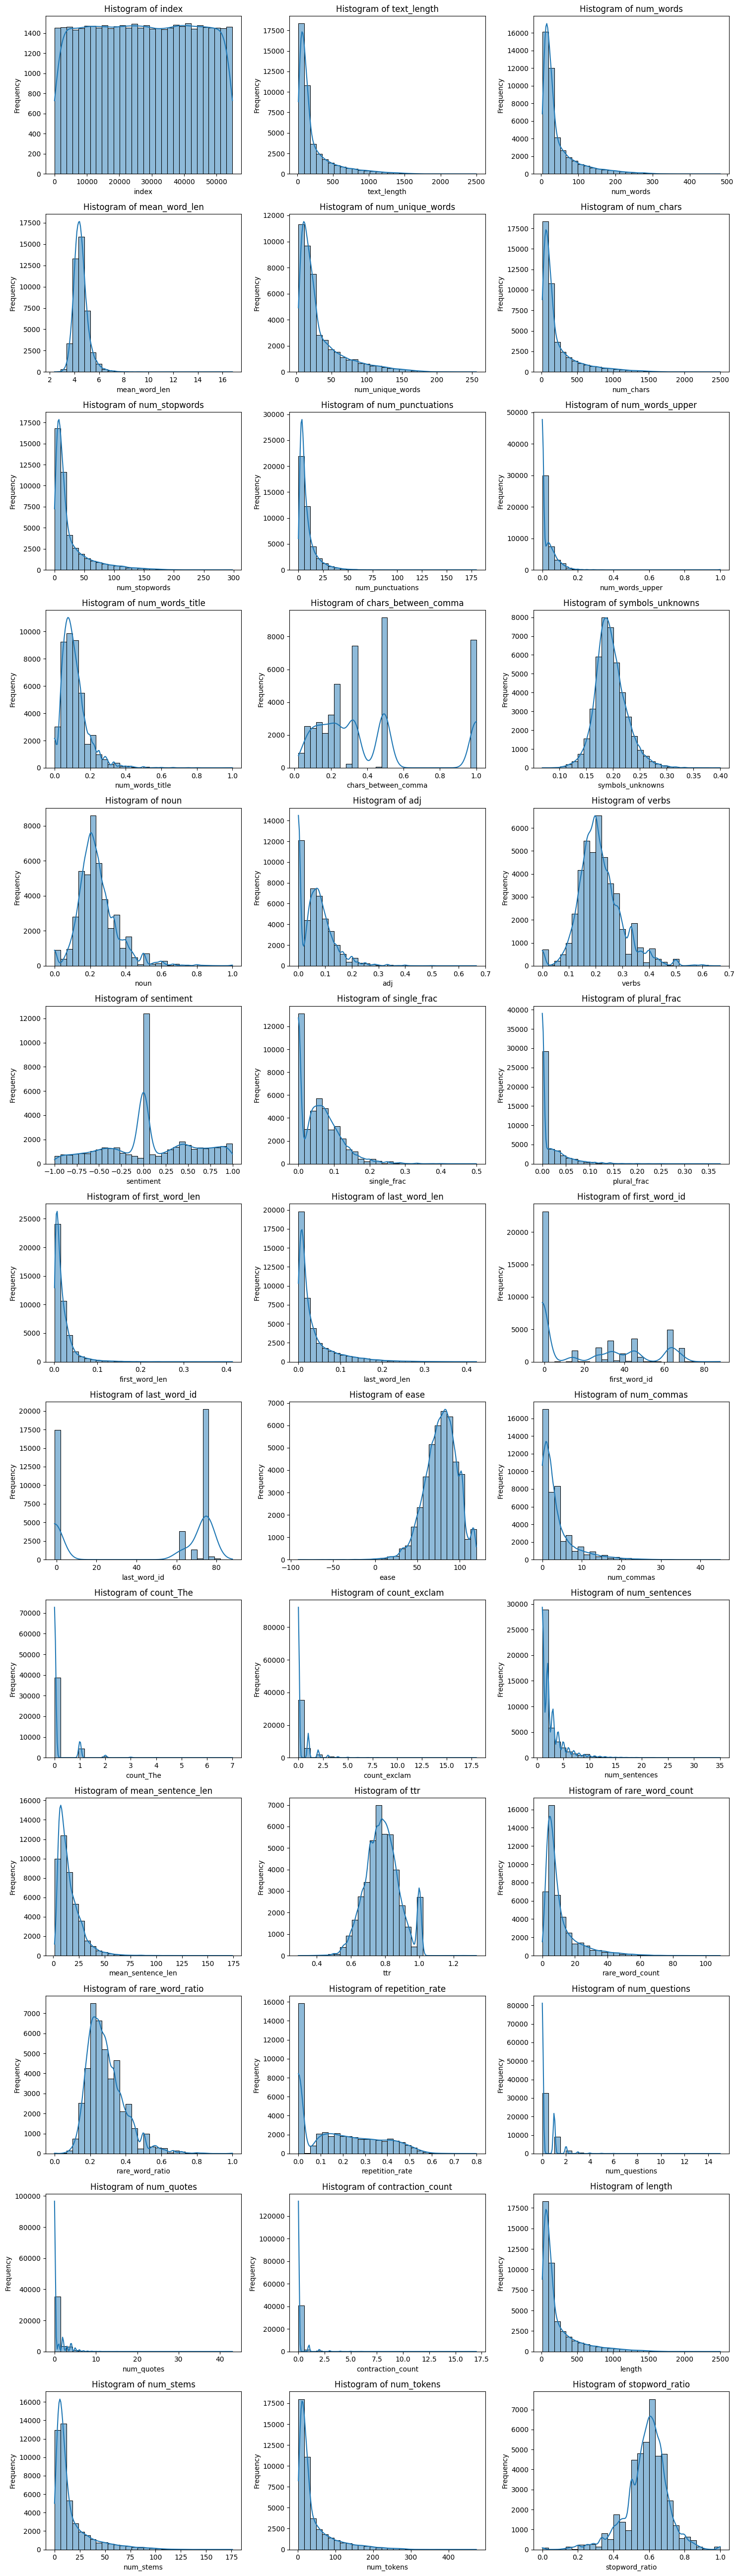

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 피처만 선택
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# 히스토그램 그리기
num_cols = len(numeric_cols)
ncols = 3  # 한 행에 3개씩
nrows = (num_cols + ncols - 1) // ncols  # 행 개수 계산

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(nrows, ncols, i + 1)
    sns.histplot(X_train[col].dropna(), kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Numeric 변수 히트맵

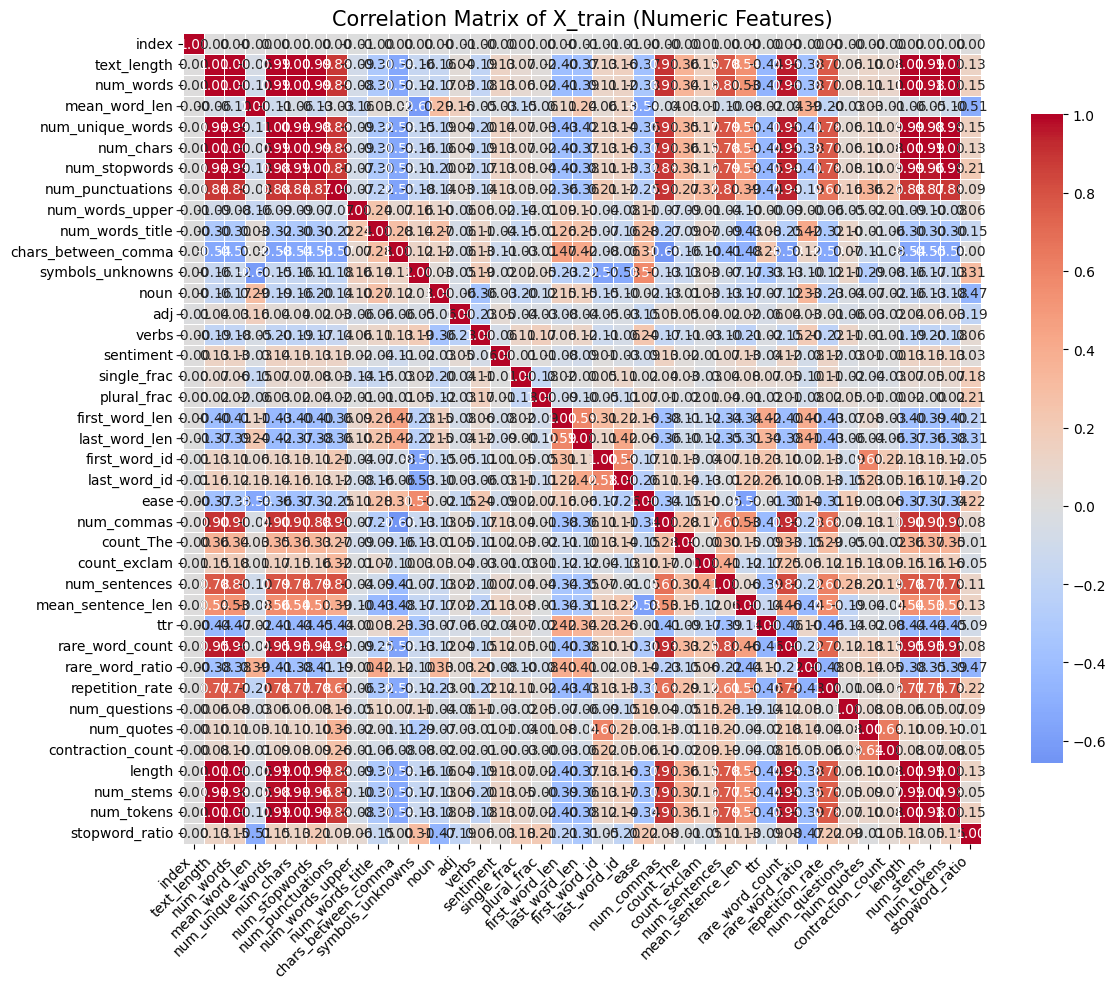

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 피처만 선택
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X_train[numeric_cols]

# 상관관계 행렬 계산
corr_matrix = X_numeric.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of X_train (Numeric Features)', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

-> 다중 공산성 위험 있음

text_length, text 등의 correlation 이 매우 높음

Numeric 변수 피처 스케일링 진행
- 원본/ 로그 변환/ Box-Cox/ StandardScaler 진행 후 왜도 비교
- 왜도의 절댓값이 가장 작은 방법 채택

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, boxcox

# 1. 수치형 및 비수치형 변수 분리
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_cols].copy()
X_train_other = X_train.drop(columns=numeric_cols)

# 2. 왜도 계산 함수
def compute_skew(df):
    return df.apply(lambda x: skew(x.dropna()))

# 3. 원본 왜도
skew_original = compute_skew(X_train_numeric)

# 4. 로그 변환 후 왜도
X_log = np.log1p(X_train_numeric.where(X_train_numeric > 0))
skew_log = compute_skew(X_log)

# 5. Box-Cox 변환 후 왜도
X_boxcox = pd.DataFrame(index=X_train_numeric.index)
skew_boxcox = {}
for col in X_train_numeric.columns:
    if (X_train_numeric[col] > 0).all():
        transformed, _ = boxcox(X_train_numeric[col])
        X_boxcox[col] = transformed
        skew_boxcox[col] = skew(transformed)
    else:
        skew_boxcox[col] = np.nan
skew_boxcox = pd.Series(skew_boxcox)

# 6. StandardScaler 정규화 후 왜도
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_numeric), columns=numeric_cols)
skew_scaled = compute_skew(X_train_scaled)

# 7. 왜도 테이블 생성
skew_df = pd.DataFrame({
    'Original': skew_original,
    'Log': skew_log,
    'Box-Cox': skew_boxcox,
    'StandardScaler': skew_scaled
})

# 8. 절댓값 기준으로 가장 왜도가 작은 방식 선택
skew_df['Min |Skew|'] = skew_df[['Original', 'Log', 'Box-Cox', 'StandardScaler']].abs().min(axis=1)
skew_df['Best Method'] = skew_df[['Original', 'Log', 'Box-Cox', 'StandardScaler']].apply(
    lambda row: row.abs().idxmin(), axis=1
)

In [ ]:
skew_df = skew_df.sort_values('Min |Skew|', ascending=True)
print(skew_df.round(3))

                     Original     Log  Box-Cox  StandardScaler  Min |Skew|  \
index                  -0.000  -1.992      NaN          -0.000       0.000   
last_word_len           2.482   2.285    0.000           2.482       0.000   
mean_sentence_len       2.575   0.208    0.003           2.575       0.003   
first_word_len          3.569   3.267   -0.004           3.569       0.004   
ttr                     0.136  -0.038    0.004           0.136       0.004   
symbols_unknowns        0.569   0.457    0.009           0.569       0.009   
chars_between_comma     0.997   0.745   -0.027           0.997       0.027   
mean_word_len           1.329   0.625   -0.039           1.329       0.039   
num_unique_words        1.924   0.375    0.040           1.924       0.040   
num_tokens              2.315   0.483    0.053           2.315       0.053   
num_chars               2.349   0.445    0.053           2.349       0.053   
text_length             2.349   0.445    0.053           2.349  

- 채택한 방법 적용 후 피처 저장 (X_train_final, X_val_final)

In [ ]:
# 0이 아닌 값의 개수를 칼럼별로 계산
non_zero_counts = (X_numeric != 0).sum()

# 결과 출력
print("각 칼럼별 0이 아닌 값의 개수:")
print(non_zero_counts)

각 칼럼별 0이 아닌 값의 개수:
index                  43788
text_length            43789
num_words              43789
mean_word_len          43789
num_unique_words       43789
num_chars              43789
num_stopwords          43703
num_punctuations       43730
num_words_upper        19889
num_words_title        42442
chars_between_comma    43789
symbols_unknowns       43789
noun                   42915
adj                    32195
verbs                  43076
sentiment              31850
single_frac            31199
plural_frac            16631
first_word_len         43789
last_word_len          43789
first_word_id          43786
last_word_id           43788
ease                   43789
num_commas             35977
count_The               5063
count_exclam            8560
num_sentences          43789
mean_sentence_len      43789
ttr                    43789
rare_word_count        43773
rare_word_ratio        43773
repetition_rate        27933
num_questions          11216
num_quotes             1

로그 변환을 하는 값들 중 0이 있어서 NA발생. 따라서 1씩 shift하여 해결한다.

In [ ]:
X_train_best = pd.DataFrame(index=X_train.index)
scalers   = {}
for col in numeric_cols:
    method = skew_df.loc[col, 'Best Method']
    if method == 'Original':
        X_train_best[col] = X_train_numeric[col]
    elif method == 'Log':
        X_train_best[col] = np.log1p(X_train_numeric[col] + 1)
    elif method == 'Box-Cox':
        X_train_best[col], fitted_lambda = boxcox(X_train_numeric[col])
        scalers[col] = fitted_lambda
    else:  # StandardScaler
        sc = StandardScaler()
        X_train_best[col] = sc.fit_transform(X_train_numeric[[col]])
        scalers[col] = sc

# val 데이터에도 적용
X_val_num   = X_val[numeric_cols].copy()
X_val_best  = pd.DataFrame(index=X_val.index)
for col in numeric_cols:
    method = skew_df.loc[col, 'Best Method']
    if method == 'Original':
        X_val_best[col] = X_val_num[col]
    elif method == 'Log':
        X_val_best[col] = np.log1p(X_val_num[col] + 1)
    elif method == 'Box-Cox' and col in scalers:
        X_val_best[col] = boxcox(X_val_num[col], lmbda=scalers[col])
    else:  # StandardScaler
        X_val_best[col] = scalers[col].transform(X_val_num[[col]])

# 비수치형 결합
X_train_final = pd.concat([X_train_best, X_train.drop(columns=numeric_cols)], axis=1)
X_val_final= pd.concat([X_val_best, X_val.drop(columns=numeric_cols)], axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54737 entries, 0 to 54736
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                54737 non-null  int64  
 1   text                 54737 non-null  object 
 2   author               54737 non-null  int64  
 3   text_length          54737 non-null  int64  
 4   num_words            54737 non-null  int64  
 5   mean_word_len        54737 non-null  float64
 6   num_unique_words     54737 non-null  int64  
 7   num_chars            54737 non-null  int64  
 8   num_stopwords        54737 non-null  int64  
 9   num_punctuations     54737 non-null  int64  
 10  num_words_upper      54737 non-null  float64
 11  num_words_title      54737 non-null  float64
 12  chars_between_comma  54737 non-null  float64
 13  symbols_unknowns     54737 non-null  float64
 14  noun                 54737 non-null  float64
 15  adj                  54737 non-null 

In [ ]:
X_train_final

,index,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,...,length,num_stems,num_tokens,stopword_ratio,text,tokens,stems,_filtered_tokens,stemmed_tokens,lemmatized_tokens
42331,0.946294,2.761781,1.761634,0.826279,1.913047,2.761781,2.197225,1.098612,0.741937,0.741937,...,2.761781,1.609438,1.851696,0.700000,i then bound myself once more to the prescribe...,"['i', 'then', 'bound', 'myself', 'once', 'more...","['bound', 'prescrib', 'condit']","['bound', 'prescribed', 'conditions']","['bound', 'prescrib', 'condit']","['bound', 'prescribe', 'condition']"
36384,0.569511,2.904461,1.981752,0.844747,2.088108,2.904461,2.302585,1.945910,0.693147,0.757686,...,2.904461,1.945910,2.014267,0.615385,“what! take orders without a living! no; that ...,"['“', 'what', '!', 'take', 'orders', 'without'...","['order', 'live', 'mad', 'absolut', 'mad']","['orders', 'living', 'madness', 'absolute', 'm...","['order', 'live', 'mad', 'absolut', 'mad']","['order', 'live', 'madness', 'absolute', 'madn..."
16358,-0.698776,3.007896,2.148587,0.814184,2.328181,3.007896,2.302585,1.791759,0.693147,0.784119,...,3.007896,2.197225,2.099464,0.533333,mr. odin and mrs. joe stared at one another—as...,"['mr.', 'odin', 'and', 'mrs.', 'joe', 'stared'...","['odin', 'joe', 'stare', 'repeat', 'black', 'v...","['odin', 'joe', 'stared', 'repeated', 'black',...","['odin', 'joe', 'stare', 'repeat', 'black', 'v...","['odin', 'joe', 'star', 'repeated', 'black', '..."
4457,-1.452026,3.344265,2.601237,0.767387,2.875942,3.344265,3.637586,2.484907,0.709148,0.763215,...,3.344265,3.135494,2.788695,0.631579,"‘no, sir,’ said my aunt. ‘certainly not!’ with...","['‘', 'no', ',', 'sir', ',', '’', 'said', 'my'...","['sir', 'said', 'aunt', 'certain', 'push', 'co...","['sir', 'said', 'aunt', 'certainly', 'pushed',...","['sir', 'said', 'aunt', 'certainli', 'push', '...","['sir', 'say', 'aunt', 'certainly', 'push', 'c..."
40003,0.798690,3.059972,2.247594,0.811488,2.416944,3.059972,2.564949,1.791759,0.693147,0.749237,...,3.059972,2.564949,2.316031,0.500000,"“here they are!” said miss pross, rising to br...","['“', 'here', 'they', 'are', '!', '”', 'said',...","['said', 'miss', 'pross', 'rise', 'break', 'co...","['said', 'miss', 'pross', 'rising', 'break', '...","['said', 'miss', 'pross', 'rise', 'break', 'co...","['say', 'miss', 'pross', 'rise', 'break', 'con..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,1.098575,3.397661,2.629304,0.800384,2.896341,3.397661,3.713572,2.484907,0.707962,0.715288,...,3.397661,3.218876,2.826342,0.629032,"“i cannot pretend to be sorry,” said odin, af...","['“', 'i', 'can', 'not', 'pretend', 'to', 'be'...","['pretend', 'sorri', 'said', 'odin', 'short', ...","['pretend', 'sorry', 'said', 'odin', 'short', ...","['pretend', 'sorri', 'said', 'odin', 'short', ...","['pretend', 'sorry', 'say', 'odin', 'short', '..."
54343,1.708518,3.683745,2.927877,0.827892,3.265664,3.683745,4.615121,3.526361,0.693147,0.710640,...,3.683745,4.127134,3.208083,0.622642,mr. odin's strains were more solemn. mrs. odin...,"['mr.', 'odin', ""'s"", 'strains', 'were', 'more...","['odin', 'strain', 'solemn', 'odin', 'unfortun...","['odin', 'strains', 'solemn', 'odin', 'unfortu...","['odin', 'strain', 'solemn', 'odin', 'unfortun...","['odin', 'strain', 'solemn', 'odin', 'unfortun..."
38158,0.681794,3.528290,2.787886,0.789594,3.111848,3.528290,4.219508,2.639057,0.702450,0.716243,...,3.528290,3.637586,3.036927,0.647059,“how was it possible that such an idea should...,"['“', 'how', 'was', 'it', 'possible', 'that', ...","['possibl', 'idea', 'enter', 'brain', 'felt', ...","['possible', 'idea', 'enter', 'brains', 'felt'...","['possibl', 'idea', 'enter', 'brain', 'felt', ...","['possible', 'idea', 'enter', 'brain', 'felt',..."
860,-1.679689,2.447710,1.630877,0.782892,1.549493,2.447710,1.609438,1.609438,0.693147,0.753772,...,2.447710,1.609438,1.510054,0.500000,"‘sir odin!’ she said, at last

In [ ]:
X_val_final

,index,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,...,length,num_stems,num_tokens,stopword_ratio,text,tokens,stems,_filtered_tokens,stemmed_tokens,lemmatized_tokens
13497,-0.879932,3.603161,2.887617,0.767806,3.217556,3.603161,4.574711,3.135494,0.709898,0.742581,...,3.603161,3.891820,3.165895,0.669014,“we earned a living at this time by my exhibit...,"['“', 'we', 'earned', 'a', 'living', 'at', 'th...","['earn', 'live', 'time', 'exhibit', 'poor', 't...","['earned', 'living', 'time', 'exhibiting', 'po...","['earn', 'live', 'time', 'exhibit', 'poor', 't...","['earn', 'living', 'time', 'exhibit', 'poor', ..."
16196,-0.709075,2.641205,1.700782,0.848704,1.662473,2.641205,1.609438,2.079442,0.693147,0.693147,...,2.641205,1.609438,1.510054,0.500000,"""good-bye,"" she said, going towards the door.","['``', 'good-bye', ',', ""''"", 'she', 'said', '...","['said', 'go', 'door']","['said', 'going', 'door']","['said', 'go', 'door']","['say', 'go', 'door']"
49957,1.430116,2.714843,1.863311,0.796652,1.913047,2.714843,2.079442,1.386294,0.693147,0.773190,...,2.714843,1.791759,1.851696,0.600000,"“the light is something in my eyes,” said the ...","['“', 'the', 'light', 'is', 'something', 'in',...","['light', 'eye', 'said', 'master']","['light', 'eyes', 'said', 'master']","['light', 'eye', 'said', 'master']","['light', 'eye', 'say', 'master']"
16723,-0.675712,2.840419,2.100385,0.733779,2.180420,2.840419,2.772589,2.197225,0.719123,0.769133,...,2.840419,1.386294,2.137111,0.875000,"""he has. he has said that it can be done and t...","['``', 'he', 'has', '.', 'he', 'has', 'said', ...","['said', 'right']","['said', 'right']","['said', 'right']","['say', 'right']"
41283,0.879885,2.523178,1.630877,0.826279,1.549493,2.523178,1.386294,1.386294,0.693147,0.753772,...,2.523178,1.791759,1.510054,0.333333,"“the candle shows that,” said odin.","['“', 'the', 'candle', 'shows', 'that', ',', '...","['candl', 'show', 'said', 'odin']","['candle', 'shows', 'said', 'odin']","['candl', 'show', 'said', 'odin']","['candle', 'show', 'say', 'odin']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22839,-0.288440,3.321302,2.563588,0.792097,2.796249,3.321302,3.496508,2.772589,0.693147,0.736822,...,3.321302,3.044522,2.728773,0.620000,"“you ought to be whipped, odin, you silly boy....","['“', 'you', 'ought', 'to', 'be', 'whipped', '...","['ought', 'whip', 'odin', 'silli', 'boy', 'wan...","['ought', 'whipped', 'odin', 'silly', 'boy', '...","['ought', 'whip', 'odin', 'silli', 'boy', 'wan...","['ought', 'whip', 'odin', 'silly', 'boy', 'wan..."
45010,1.116267,3.000735,2.211092,0.793824,2.328181,3.000735,2.708050,2.397895,0.733969,0.753772,...,3.000735,2.197225,2.263652,0.650000,"""no, ma'am--the horses were just coming out, b...","['``', 'no', ',', ""ma'am"", '--', 'the', 'horse...","['hors', 'just', 'come', 'bide', 'longer', 'af...","['horses', 'just', 'coming', 'bide', 'longer',...","['hors', 'just', 'come', 'bide', 'longer', 'af...","['horse', 'just', 'come', 'bide', 'longer', 'a..."
16356,-0.698902,3.582264,2.841553,0.793496,3.140956,3.582264,4.356709,3.135494,0.697076,0.727967,...,3.582264,3.828641,3.101326,0.633333,miss odin was not slow to admire; she pretty w...,"['miss', 'odin', 'was', 'not', 'slow', 'to', '...","['miss', 'odin', 'slow', 'admir', 'pretti', 'g...","['miss', 'odin', 'slow', 'admire', 'pretty', '...","['miss', 'odin', 'slow', 'admir', 'pretti', 'g...","['miss', 'odin', 'slow', 'admire', 'pretty', '..."
44006,1.052512,3.119663,2.229797,0.842135,2.443434,3.119663,2.397895,2.079442,0.732368,0.770108,...,3.119663,2.708050,2.316031,0.409091,halloa being a general observation which i had...,"['halloa', 'being', 'a', 'general', 'observati...","['halloa', 'general', 'observ', 'usual', 'obse...","['halloa', 'general', 'observation', 'usually'...","['halloa', 'gener', 'observ', 'usual', 'observ...","['halloa', 'general', 'observation', 'usually'..."


꺄악 해결

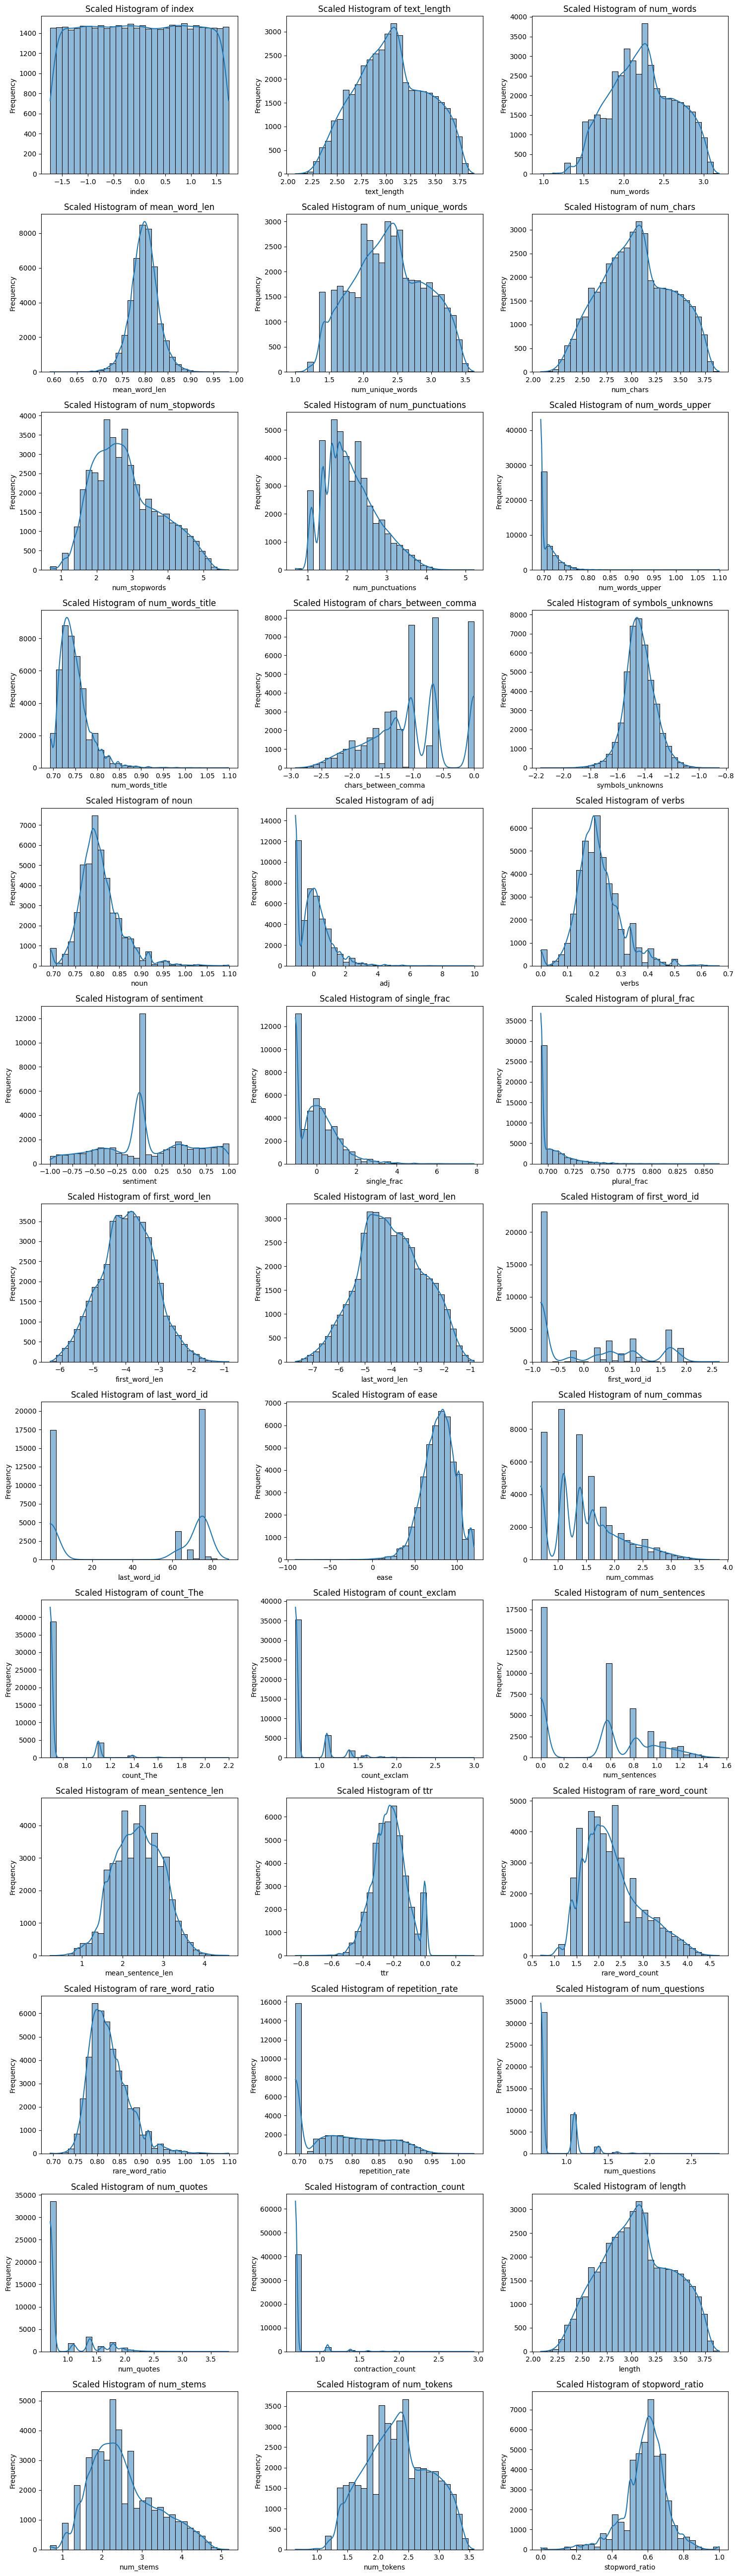

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 피처만 선택
scaled_numeric_cols = X_train_final.select_dtypes(include=['int64', 'float64']).columns

# 히스토그램 그리기
num_cols = len(scaled_numeric_cols)
ncols = 3  # 한 행에 3개씩
nrows = (num_cols + ncols - 1) // ncols  # 필요한 행 수 계산

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(scaled_numeric_cols):
    plt.subplot(nrows, ncols, i + 1)
    sns.histplot(X_train_final[col].dropna(), kde=True, bins=30)
    plt.title(f"Scaled Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
# 1. 수치형 피처 분리
X_test_num = test[numeric_cols].copy()
X_test_best = pd.DataFrame(index=test.index)

# 2. 수치형 피처에 대해 훈련 데이터에서 결정된 전처리 방식 적용
for col in numeric_cols:
    method = skew_df.loc[col, 'Best Method']
    if method == 'Original':
        X_test_best[col] = X_test_num[col]
    elif method == 'Log':
        X_test_best[col] = np.log1p(X_test_num[col] + 1)
    elif method == 'Box-Cox' and col in scalers:
        X_test_best[col] = boxcox(X_test_num[col], lmbda=scalers[col])
    elif method == 'StandardScaler' and col in scalers:
        X_test_best[col] = scalers[col].transform(X_test_num[[col]])
    else:
        X_test_best[col] = X_test_num[col]  # fallback

# 3. 비수치형 피처 결합
X_test_final = pd.concat([X_test_best, test.drop(columns=numeric_cols)], axis=1)

# 4. 필요 없는 칼럼 제거
X_test_scaled = X_test_final.drop(columns=['index', 'text','tokens','stems','_filtered_tokens','stemmed_tokens','lemmatized_tokens'], errors='ignore')

### 피쳐 중요도 (트리기반 모델)

In [ ]:
X_train_scaled = X_train_final.drop(columns=['index', 'text','tokens','stems','_filtered_tokens','stemmed_tokens','lemmatized_tokens'])
X_val_scaled = X_val_final.drop(columns=['index', 'text','tokens','stems','_filtered_tokens','stemmed_tokens','lemmatized_tokens'])

In [ ]:
X_train_scaled.head()

,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,chars_between_comma,...,rare_word_count,rare_word_ratio,repetition_rate,num_questions,num_quotes,contraction_count,length,num_stems,num_tokens,stopword_ratio
42331,2.761781,1.761634,0.826279,1.913047,2.761781,2.197225,1.098612,0.741937,0.741937,0.000000,...,1.386294,0.788457,0.693147,0.693147,0.693147,0.693147,2.761781,1.609438,1.851696,0.700000
36384,2.904461,1.981752,0.844747,2.088108,2.904461,2.302585,1.945910,0.693147,0.757686,0.000000,...,2.079442,0.875469,0.693147,0.693147,0.693147,0.693147,2.904461,1.945910,2.014267,0.615385
16358,3.007896,2.148587,0.814184,2.328181,3.007896,2.302585,1.791759,0.693147,0.784119,-0.666712,...,2.397895,0.887303,0.693147,1.098612,0.693147,0.693147,3.007896,2.197225,2.099464,0.533333
4457,3.344265,2.601237,0.767387,2.875942,3.344265,3.637586,2.484907,0.709148,0.763215,-1.584709,...,2.772589,0.800119,0.829906,0.693147,0.693147,0.693147,3.344265,3.135494,2.788695,0.631579
40003,3.059972,2.247594,0.811488,2.416944,3.059972,2.564949,1.791759,0.693147,0.749237,-0.665627,...,2.197225,0.819441,0.693147,0.693147,0.693147,0.693147,3.059972,2.564949,2.316031,0.500000


In [ ]:
X_val_scaled.head()

,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,chars_between_comma,...,rare_word_count,rare_word_ratio,repetition_rate,num_questions,num_quotes,contraction_count,length,num_stems,num_tokens,stopword_ratio
13497,3.603161,2.887617,0.767806,3.217556,3.603161,4.574711,3.135494,0.709898,0.742581,-1.956151,...,3.526361,0.795801,0.897942,0.693147,0.693147,0.693147,3.603161,3.891820,3.165895,0.669014
16196,2.641205,1.700782,0.848704,1.662473,2.641205,1.609438,2.079442,0.693147,0.693147,-1.051299,...,1.609438,0.847298,0.693147,0.693147,1.386294,0.693147,2.641205,1.609438,1.510054,0.500000
49957,2.714843,1.863311,0.796652,1.913047,2.714843,2.079442,1.386294,0.693147,0.773190,-0.675477,...,1.609438,0.810930,0.693147,0.693147,0.693147,0.693147,2.714843,1.791759,1.851696,0.600000
16723,2.840419,2.100385,0.733779,2.180420,2.840419,2.772589,2.197225,0.719123,0.769133,0.000000,...,1.791759,0.793231,0.753772,0.693147,1.386294,0.693147,2.840419,1.386294,2.137111,0.875000
41283,2.523178,1.630877,0.826279,1.549493,2.523178,1.386294,1.386294,0.693147,0.753772,-0.684403,...,1.791759,0.916291,0.693147,0.693147,0.693147,0.693147,2.523178,1.791759,1.510054,0.333333


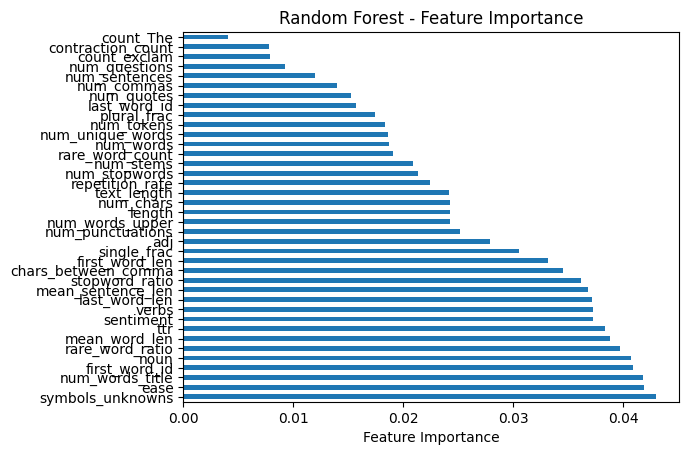

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as pltm

# 예시 데이터
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

# 피처 중요도 추출
importances = model.feature_importances_
feature_names = X_train_scaled.columns  # pandas DataFrame일 경우

# 시각화
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.show()

- 상위 10개 피처

In [ ]:
# 상위 10개 피처 선택
top_n = 10
top_features = feat_imp.head(top_n).index

# 선택된 피처 출력
print("상위 10개 피처:")
print(top_features)

상위 10개 피처:
Index(['symbols_unknowns', 'ease', 'num_words_title', 'first_word_id', 'noun',
       'rare_word_ratio', 'mean_word_len', 'ttr', 'sentiment', 'verbs'],
      dtype='object')


- 누적 중요도가 95% 이상이 될 때까지 피처를 선택

In [ ]:
# 중요도에 따른 누적 중요도 계산
cumulative_importance = feat_imp.cumsum()

# 누적 중요도가 95% 이상인 피처까지 선택
selected_features = cumulative_importance[cumulative_importance >= 0.95].index

# 선택된 피처 출력
print("누적 중요도가 95% 이상인 피처:")
print(selected_features)

누적 중요도가 95% 이상인 피처:
Index(['num_commas', 'num_sentences', 'num_questions', 'count_exclam',
       'contraction_count', 'count_The'],
      dtype='object')


-> 선택된 피처가 약간 서로 다름 : 다중공선성 문제 해결 필요

In [ ]:
tail_features = feat_imp.tail(7).index

# 선택된 피처 출력
print("하위 7개 피처:")
print(tail_features)

하위 7개 피처:
Index(['num_quotes', 'num_commas', 'num_sentences', 'num_questions',
       'count_exclam', 'contraction_count', 'count_The'],
      dtype='object')


### 다중 공선성 확인 및 해결

1. 상관관계가 0.8 이상인 두 피쳐 중 한 가지 삭제

In [ ]:
import pandas as pd
import numpy as np

# 상관관계 계산
corr_matrix = X_train_scaled.corr()

# 상관계수 threshold 설정 (예: 0.9 이상)
threshold = 0.8

# 상관관계가 높은 피처를 제거
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

# 상관관계가 높은 피처들 제거
X_train_scaled_no_multicollinearity = X_train_scaled.drop(columns=to_drop)

# 다중공선성 제거 후 남은 피처들
print("다중공선성 해결 후 남은 피처들:")
print(X_train_scaled_no_multicollinearity.columns)

# 삭제된 피처들 출력
print("\n삭제된 피처들:")
print(to_drop)

다중공선성 해결 후 남은 피처들:
Index(['text_length', 'mean_word_len', 'num_words_upper', 'num_words_title',
       'symbols_unknowns', 'noun', 'adj', 'verbs', 'sentiment', 'single_frac',
       'plural_frac', 'last_word_len', 'first_word_id', 'last_word_id', 'ease',
       'count_The', 'count_exclam', 'num_sentences', 'mean_sentence_len',
       'ttr', 'rare_word_ratio', 'num_questions', 'num_quotes',
       'contraction_count', 'stopword_ratio'],
      dtype='object')

삭제된 피처들:
{'num_words', 'repetition_rate', 'first_word_len', 'num_commas', 'num_unique_words', 'chars_between_comma', 'num_chars', 'num_tokens', 'length', 'num_punctuations', 'num_stopwords', 'rare_word_count', 'num_stems'}


VIF

- 해당 변수의 분산이 다른 변수들과의 상관관계로 인해 얼마나 부풀려졌는가?를 보여줌

- VIF 값	해석

  - 1	다중공선성 없음

  - 1 ~ 5	문제 없거나 약한 다중공선성

  - 5 ~ 10	주의 요함. 공선성이 의심됨

  - 10 이상	심각한 다중공선성. 조치 필요

In [ ]:
X_train_scaled_no_multicollinearity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43789 entries, 42331 to 15795
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text_length        43789 non-null  float64
 1   mean_word_len      43789 non-null  float64
 2   num_words_upper    43789 non-null  float64
 3   num_words_title    43789 non-null  float64
 4   symbols_unknowns   43789 non-null  float64
 5   noun               43789 non-null  float64
 6   adj                43789 non-null  float64
 7   verbs              43789 non-null  float64
 8   sentiment          43789 non-null  float64
 9   single_frac        43789 non-null  float64
 10  plural_frac        43789 non-null  float64
 11  last_word_len      43789 non-null  float64
 12  first_word_id      43789 non-null  float64
 13  last_word_id       43789 non-null  int64  
 14  ease               43789 non-null  float64
 15  count_The          43789 non-null  float64
 16  count_exclam       4378

In [ ]:
X_train_scaled_no_multicollinearity.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
X_train_scaled_no_multicollinearity.dropna(inplace=True)

In [ ]:
X_train_scaled_no_multicollinearity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43789 entries, 42331 to 15795
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text_length        43789 non-null  float64
 1   mean_word_len      43789 non-null  float64
 2   num_words_upper    43789 non-null  float64
 3   num_words_title    43789 non-null  float64
 4   symbols_unknowns   43789 non-null  float64
 5   noun               43789 non-null  float64
 6   adj                43789 non-null  float64
 7   verbs              43789 non-null  float64
 8   sentiment          43789 non-null  float64
 9   single_frac        43789 non-null  float64
 10  plural_frac        43789 non-null  float64
 11  last_word_len      43789 non-null  float64
 12  first_word_id      43789 non-null  float64
 13  last_word_id       43789 non-null  int64  
 14  ease               43789 non-null  float64
 15  count_The          43789 non-null  float64
 16  count_exclam       4378

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

if not isinstance(X_train_scaled_no_multicollinearity, pd.DataFrame):
    X_train_scaled_no_multicollinearity = pd.DataFrame(X_train_scaled_no_multicollinearity, columns=[f'x{i}' for i in range(X_train_scaled_no_multicollinearity.shape[1])])

# VIF 계산
vif_data = pd.DataFrame()
vif_data["변수"] = X_train_scaled_no_multicollinearity.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_no_multicollinearity.values, i) for i in range(X_train_scaled_no_multicollinearity.shape[1])]

print(vif_data)

                   변수          VIF
0         text_length  7039.237635
1       mean_word_len  4098.559755
2     num_words_upper   776.958151
3     num_words_title   765.025891
4    symbols_unknowns   968.747998
5                noun   644.064765
6                 adj     1.313913
7               verbs    15.362159
8           sentiment     1.065208
9         single_frac     1.150727
10        plural_frac  2059.203899
11      last_word_len   119.977219
12      first_word_id     3.742037
13       last_word_id    13.149969
14               ease    47.500572
15          count_The    29.300294
16       count_exclam    16.396164
17      num_sentences    88.450643
18  mean_sentence_len   871.985944
19                ttr    10.024204
20    rare_word_ratio   739.730084
21      num_questions    16.886324
22         num_quotes    19.030334
23  contraction_count    34.582628
24     stopword_ratio    54.060316


반복적으로 VIF가 높은 변수 제거하기 (10 이상은 제거)

In [ ]:
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["변수"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# 반복적으로 VIF 높은 변수 제거
threshold = 10
while True:
    vif_df = calculate_vif(X_train_scaled_no_multicollinearity)
    max_vif = vif_df['VIF'].max()
    if max_vif > threshold:
        drop_col = vif_df.sort_values('VIF', ascending=False).iloc[0]['변수']
        print(f"🔻 Removing '{drop_col}' with VIF = {max_vif}")
        X_train_scaled_no_multicollinearity = X_train_scaled_no_multicollinearity.drop(columns=[drop_col])
    else:
        break

print("\n✅ 최종 VIF 결과:")
print(calculate_vif(X_train_scaled_no_multicollinearity))

🔻 Removing 'text_length' with VIF = 7039.237634617662
🔻 Removing 'mean_word_len' with VIF = 2887.473233812896
🔻 Removing 'plural_frac' with VIF = 1771.0973640194316
🔻 Removing 'num_words_title' with VIF = 739.4031841222752
🔻 Removing 'num_words_upper' with VIF = 603.5334000563756
🔻 Removing 'rare_word_ratio' with VIF = 557.9675549903471
🔻 Removing 'noun' with VIF = 276.52098944460437
🔻 Removing 'last_word_len' with VIF = 113.74860471769091
🔻 Removing 'symbols_unknowns' with VIF = 88.08044803581512
🔻 Removing 'stopword_ratio' with VIF = 34.15130686204405
🔻 Removing 'contraction_count' with VIF = 31.742528342224933
🔻 Removing 'count_The' with VIF = 23.15163642995745
🔻 Removing 'ease' with VIF = 16.893811825826507
🔻 Removing 'num_questions' with VIF = 12.569833433338365
🔻 Removing 'count_exclam' with VIF = 11.413075333912607
🔻 Removing 'mean_sentence_len' with VIF = 10.428509515038234

✅ 최종 VIF 결과:
              변수       VIF
0            adj  1.056165
1          verbs  6.570179
2      sen

In [ ]:
# train에서 남긴 최종 피처 컬럼 리스트
selected_cols = X_train_scaled_no_multicollinearity.columns.tolist()

# 검증셋에도 같은 컬럼만 추출
X_val_scaled_no_multicollinearity = X_val_scaled[selected_cols].copy()

# 무한대/결측 처리(훈련셋과 동일하게)
X_val_scaled_no_multicollinearity = (
    X_val_scaled_no_multicollinearity
      .replace([np.inf, -np.inf], pd.NA)
      .dropna()
)

# 확인
print(X_val_scaled_no_multicollinearity.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10948 entries, 13497 to 7237
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   adj            10948 non-null  float64
 1   verbs          10948 non-null  float64
 2   sentiment      10948 non-null  float64
 3   single_frac    10948 non-null  float64
 4   first_word_id  10948 non-null  float64
 5   last_word_id   10948 non-null  int64  
 6   num_sentences  10948 non-null  float64
 7   ttr            10948 non-null  float64
 8   num_quotes     10948 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 855.3 KB
None


[최종 피쳐들]

    'adj',
    'verbs',
    'sentiment',
    'single_frac',
    'first_word_id',
    'last_word_id',
    'num_sentences',
    'ttr',
    'num_quotes'
  

In [ ]:
X_train_scaled_no_multicollinearity.head()

,adj,verbs,sentiment,single_frac,first_word_id,last_word_id,num_sentences,ttr,num_quotes
42331,0.557480,0.100000,0.0000,-1.056043,0.527295,75,0.000000,0.000000,0.693147
36384,0.174722,0.230769,-0.3810,0.131662,-0.841318,-1,0.819551,-0.136439,0.693147
16358,-0.228180,0.157895,0.2732,-1.056043,0.683707,-1,0.000000,-0.096794,0.693147
4457,-0.815167,0.172414,-0.2003,0.093349,-0.841318,75,0.819551,-0.200294,0.693147
40003,-0.347220,0.272727,0.4912,-1.056043,-0.841318,-1,0.000000,-0.158023,0.693147


- 최종 피처 리스트 test 셋에서 선택 + 동일 전처리 적용

In [ ]:
selected_cols = [
    'adj',
    'verbs',
    'sentiment',
    'single_frac',
    'first_word_id',
    'last_word_id',
    'num_sentences',
    'ttr',
    'num_quotes'
]

In [ ]:
# 선택된 피처만 추출
X_test_scaled_no_multicollinearity = X_test_scaled[selected_cols].copy()

# 무한대/결측치 처리
X_test_scaled_no_multicollinearity = (
    X_test_scaled_no_multicollinearity
        .replace([np.inf, -np.inf], pd.NA)
        .dropna()
)
print(X_test_scaled_no_multicollinearity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19606 entries, 0 to 19605
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   adj            19606 non-null  float64
 1   verbs          19606 non-null  float64
 2   sentiment      19606 non-null  float64
 3   single_frac    19606 non-null  float64
 4   first_word_id  19606 non-null  float64
 5   last_word_id   19606 non-null  int64  
 6   num_sentences  19606 non-null  float64
 7   ttr            19606 non-null  float64
 8   num_quotes     19606 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB
None


### 벡터화 + 임베딩

1. TF-IDF 적용
2. BOW 적용

In [ ]:
import ast
X_train_final['_filtered_tokens'] = X_train_final['_filtered_tokens'].apply(ast.literal_eval)
X_val_final['_filtered_tokens'] = X_val_final['_filtered_tokens'].apply(ast.literal_eval)

X_train_final['lemmatized_tokens'] = X_train_final['lemmatized_tokens'].apply(ast.literal_eval)
X_val_final['lemmatized_tokens'] = X_val_final['lemmatized_tokens'].apply(ast.literal_eval)

X_train_final['stemmed_tokens'] = X_train_final['stemmed_tokens'].apply(ast.literal_eval)
X_val_final['stemmed_tokens'] = X_val_final['stemmed_tokens'].apply(ast.literal_eval)

In [ ]:
# 0) embedding용 문자열 복원 (_filtered_tokens → 띄어쓰기로 합치기)
X_train_final['doc_for_embedding'] = X_train_final['lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))
X_val_final['doc_for_embedding'] = X_val_final['lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))

In [ ]:
X_train_final

,index,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,...,num_stems,num_tokens,stopword_ratio,text,tokens,stems,_filtered_tokens,stemmed_tokens,lemmatized_tokens,doc_for_embedding
42331,0.946294,2.761781,1.761634,0.826279,1.913047,2.761781,2.197225,1.098612,0.741937,0.741937,...,1.609438,1.851696,0.700000,i then bound myself once more to the prescribe...,"['i', 'then', 'bound', 'myself', 'once', 'more...","['bound', 'prescrib', 'condit']","[bound, prescribed, conditions]","[bound, prescrib, condit]","[bound, prescribe, condition]",bound prescribe condition
36384,0.569511,2.904461,1.981752,0.844747,2.088108,2.904461,2.302585,1.945910,0.693147,0.757686,...,1.945910,2.014267,0.615385,“what! take orders without a living! no; that ...,"['“', 'what', '!', 'take', 'orders', 'without'...","['order', 'live', 'mad', 'absolut', 'mad']","[orders, living, madness, absolute, madness]","[order, live, mad, absolut, mad]","[order, live, madness, absolute, madness]",order live madness absolute madness
16358,-0.698776,3.007896,2.148587,0.814184,2.328181,3.007896,2.302585,1.791759,0.693147,0.784119,...,2.197225,2.099464,0.533333,mr. odin and mrs. joe stared at one another—as...,"['mr.', 'odin', 'and', 'mrs.', 'joe', 'stared'...","['odin', 'joe', 'stare', 'repeat', 'black', 'v...","[odin, joe, stared, repeated, black, velvet, c...","[odin, joe, stare, repeat, black, velvet, coach]","[odin, joe, star, repeated, black, velvet, coach]",odin joe star repeated black velvet coach
4457,-1.452026,3.344265,2.601237,0.767387,2.875942,3.344265,3.637586,2.484907,0.709148,0.763215,...,3.135494,2.788695,0.631579,"‘no, sir,’ said my aunt. ‘certainly not!’ with...","['‘', 'no', ',', 'sir', ',', '’', 'said', 'my'...","['sir', 'said', 'aunt', 'certain', 'push', 'co...","[sir, said, aunt, certainly, pushed, corner, n...","[sir, said, aunt, certainli, push, corner, nea...","[sir, say, aunt, certainly, push, corner, near...",sir say aunt certainly push corner near fenced...
40003,0.798690,3.059972,2.247594,0.811488,2.416944,3.059972,2.564949,1.791759,0.693147,0.749237,...,2.564949,2.316031,0.500000,"“here they are!” said miss pross, rising to br...","['“', 'here', 'they', 'are', '!', '”', 'said',...","['said', 'miss', 'pross', 'rise', 'break', 'co...","[said, miss, pross, rising, break, conference,...","[said, miss, pross, rise, break, confer, shall...","[say, miss, pross, rise, break, conference, sh...",say miss pross rise break conference shall hun...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,1.098575,3.397661,2.629304,0.800384,2.896341,3.397661,3.713572,2.484907,0.707962,0.715288,...,3.218876,2.826342,0.629032,"“i cannot pretend to be sorry,” said odin, af...","['“', 'i', 'can', 'not', 'pretend', 'to', 'be'...","['pretend', 'sorri', 'said', 'odin', 'short', ...","[pretend, sorry, said, odin, short, interrupti...","[pretend, sorri, said, odin, short, interrupt,...","[pretend, sorry, say, odin, short, interruptio...",pretend sorry say odin short interruption man ...
54343,1.708518,3.683745,2.927877,0.827892,3.265664,3.683745,4.615121,3.526361,0.693147,0.710640,...,4.127134,3.208083,0.622642,mr. odin's strains were more solemn. mrs. odin...,"['mr.', 'odin', ""'s"", 'strains', 'were', 'more...","['odin', 'strain', 'solemn', 'odin', 'unfortun...","[odin, strains, solemn, odin, unfortunate, wom...","[odin, strain, solemn, odin, unfortun, women, ...","[odin, strain, solemn, odin, unfortunate, woma...",odin strain solemn odin unfortunate woman poor...
38158,0.681794,3.528290,2.787886,0.789594,3.111848,3.528290,4.219508,2.639057,0.702450,0.716243,...,3.637586,3.036927,0.647059,“how was it possible that such an idea should...,"['“', 'how', 'was', 'it', 'possible', 'that', ...","['possibl', 'idea', 'enter', 'brain', 'felt', ...","[possible, idea, enter, brains, felt, little, ...","[possibl, idea, enter, brain, felt, littl, lit...","[possible, idea

In [ ]:
# 상위 5개 복원 문장 확인
print(X_train_final['doc_for_embedding'].head())

# 문자열 길이(공백 제외) 분포
lengths = X_train_final['doc_for_embedding'].apply(lambda s: len(s.strip()))
print(lengths.describe())

# 빈 문서가 있는지 확인
print("빈 문서 개수:", (lengths == 0).sum())

42331                            bound prescribe condition
36384                  order live madness absolute madness
16358            odin joe star repeated black velvet coach
4457     sir say aunt certainly push corner near fenced...
40003    say miss pross rise break conference shall hun...
Name: doc_for_embedding, dtype: object
count    43789.000000
mean       103.905319
std        128.832570
min          0.000000
25%         28.000000
50%         53.000000
75%        120.000000
max       1165.000000
Name: doc_for_embedding, dtype: float64
빈 문서 개수: 143


In [ ]:
# 1) TF‑IDF 임베딩
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_text_tfidf_train = tfidf.fit_transform(X_train_final['doc_for_embedding'])
X_text_tfidf_val   = tfidf.transform(   X_val_final['doc_for_embedding'])

In [ ]:
# 2) BOW 임베딩
bow = CountVectorizer(max_features=5000, ngram_range=(1,1), stop_words='english')
X_text_bow_train = bow.fit_transform(X_train_final['doc_for_embedding'])
X_text_bow_val   = bow.transform(   X_val_final['doc_for_embedding'])

In [ ]:
# 3) 희소행렬(TF‑IDF or BOW) + dense numeric array 결합
X_final_tfidf_train = hstack([X_text_tfidf_train, X_train_scaled.values])
X_final_tfidf_val   = hstack([X_text_tfidf_val,   X_val_scaled.values])

X_final_bow_train   = hstack([X_text_bow_train,   X_train_scaled.values])
X_final_bow_val     = hstack([X_text_bow_val,     X_val_scaled.values])

# 4) 결과 모양 확인
print("TF-IDF + numeric:", X_final_tfidf_train.shape, X_final_tfidf_val.shape)
print("BOW   + numeric:", X_final_bow_train.shape,   X_final_bow_val.shape)

TF-IDF + numeric: (43789, 5038) (10948, 5038)
BOW   + numeric: (43789, 5038) (10948, 5038)


- test 데이터에 대해서도 진행

In [ ]:
import ast
from scipy.sparse import hstack

# 1. 리스트 문자열 복원
X_test_final['_filtered_tokens']    = X_test_final['_filtered_tokens'].apply(ast.literal_eval)
X_test_final['lemmatized_tokens']   = X_test_final['lemmatized_tokens'].apply(ast.literal_eval)
X_test_final['stemmed_tokens']      = X_test_final['stemmed_tokens'].apply(ast.literal_eval)

# 2. 임베딩용 문서 복원
X_test_final['doc_for_embedding'] = X_test_final['lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))

# 3. TF-IDF 및 BOW 임베딩
X_text_tfidf_test = tfidf.transform(X_test_final['doc_for_embedding'])  # 이미 학습된 vectorizer 사용
X_text_bow_test   = bow.transform(X_test_final['doc_for_embedding'])

# 4. 희소행렬 + 수치형 피처 결합
X_final_tfidf_test = hstack([X_text_tfidf_test, X_test_scaled.values])
X_final_bow_test   = hstack([X_text_bow_test,   X_test_scaled.values])

print("TF-IDF + numeric (test):", X_final_tfidf_test.shape)
print("BOW     + numeric (test):", X_final_bow_test.shape)

TF-IDF + numeric (test): (19606, 5038)
BOW     + numeric (test): (19606, 5038)


### all_estimators

In [ ]:
from sklearn.utils import all_estimators
from sklearn.metrics import accuracy_score
import warnings

# 경고 무시 (일부 모델에서 경고가 뜨는 경우 방지)
warnings.filterwarnings("ignore")

# 분류기만 가져오기
classifiers = all_estimators(type_filter='classifier')

- BOW 벡터화 데이터 기준

```
LinearSVC: 0.7128242601388382
RidgeClassifier: 0.685239313116551
BernoulliNB: 0.6562842528315674
LogisticRegressionCV: 0.6506211180124224
ExtraTreesClassifier: 0.6388381439532335
SGDClassifier: 0.6146328096455974
GradientBoostingClassifier: 0.6137194008037998
RandomForestClassifier: 0.5975520643039824
Perceptron: 0.580288637194008
PassiveAggressiveClassifier: 0.5729813664596274
```


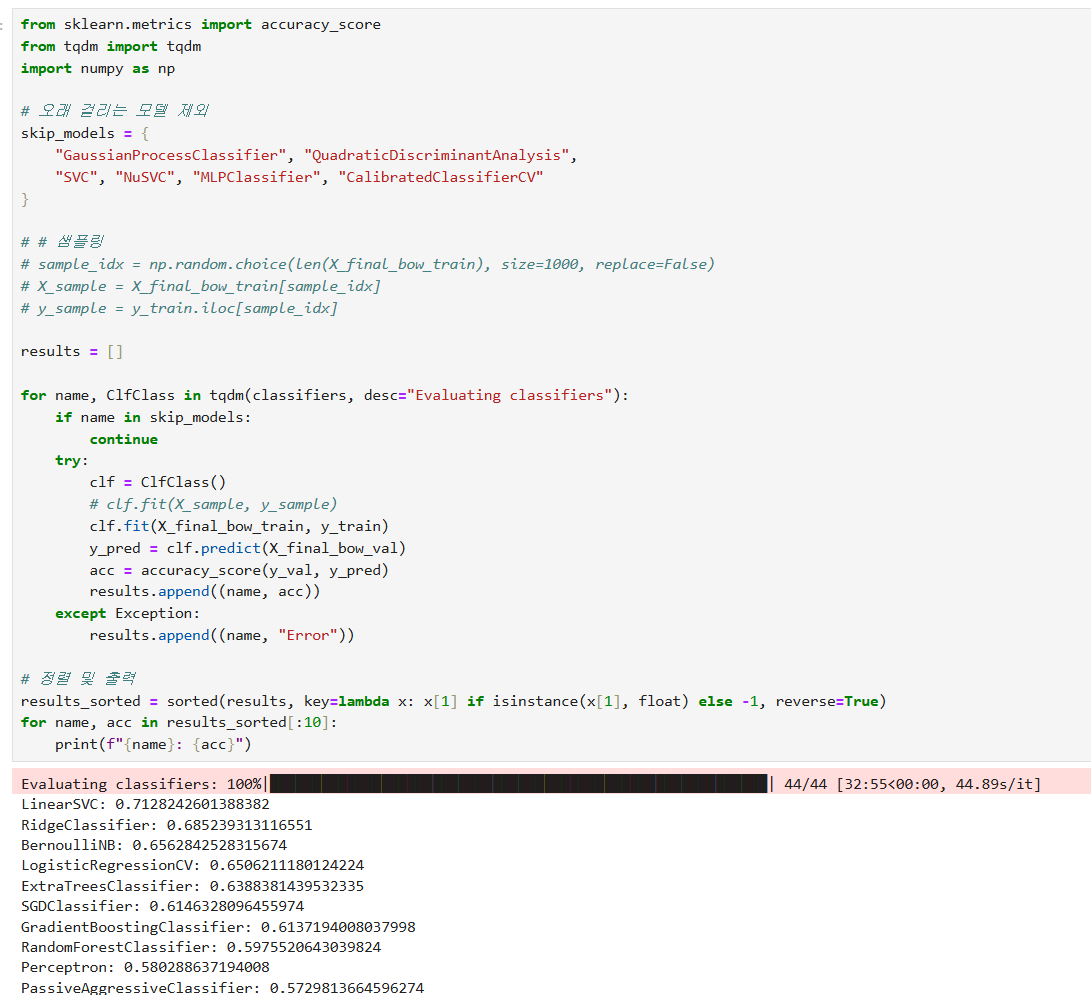

In [ ]:
# from sklearn.metrics import accuracy_score
# from tqdm import tqdm
# import numpy as np

# # 오래 걸리는 모델 제외
# skip_models = {
#     "GaussianProcessClassifier", "QuadraticDiscriminantAnalysis",
#     "SVC", "NuSVC", "MLPClassifier", "CalibratedClassifierCV"
# }

# # 샘플링
# sample_idx = np.random.choice(len(X_final_bow_train), size=1000, replace=False)
# X_sample = X_final_bow_train[sample_idx]
# y_sample = y_train.iloc[sample_idx]

# results = []

# for name, ClfClass in tqdm(classifiers, desc="Evaluating classifiers"):
#     if name in skip_models:
#         continue
#     try:
#         clf = ClfClass()
#         clf.fit(X_sample, y_sample)
#         clf.fit(X_final_bow_train, y_train)
#         y_pred = clf.predict(X_final_bow_val)
#         acc = accuracy_score(y_val, y_pred)
#         results.append((name, acc))
#     except Exception:
#         results.append((name, "Error"))

# # 정렬 및 출력
# results_sorted = sorted(results, key=lambda x: x[1] if isinstance(x[1], float) else -1, reverse=True)
# for name, acc in results_sorted[:10]:
#     print(f"{name}: {acc}")

- TF-IDF 벡터화 데이터 기준

```
LinearSVC: 0.7196748264523201
RidgeClassifier: 0.7139203507489953
RidgeClassifierCV: 0.7130982827913774
BernoulliNB: 0.6557362075264889
ExtraTreesClassifier: 0.6257763975155279
GradientBoostingClassifier: 0.6169163317500913
RandomForestClassifier: 0.600748995250274
BaggingClassifier: 0.5441176470588235
LogisticRegressionCV: 0.5271282426013884
DecisionTreeClassifier: 0.4720496894409938

```

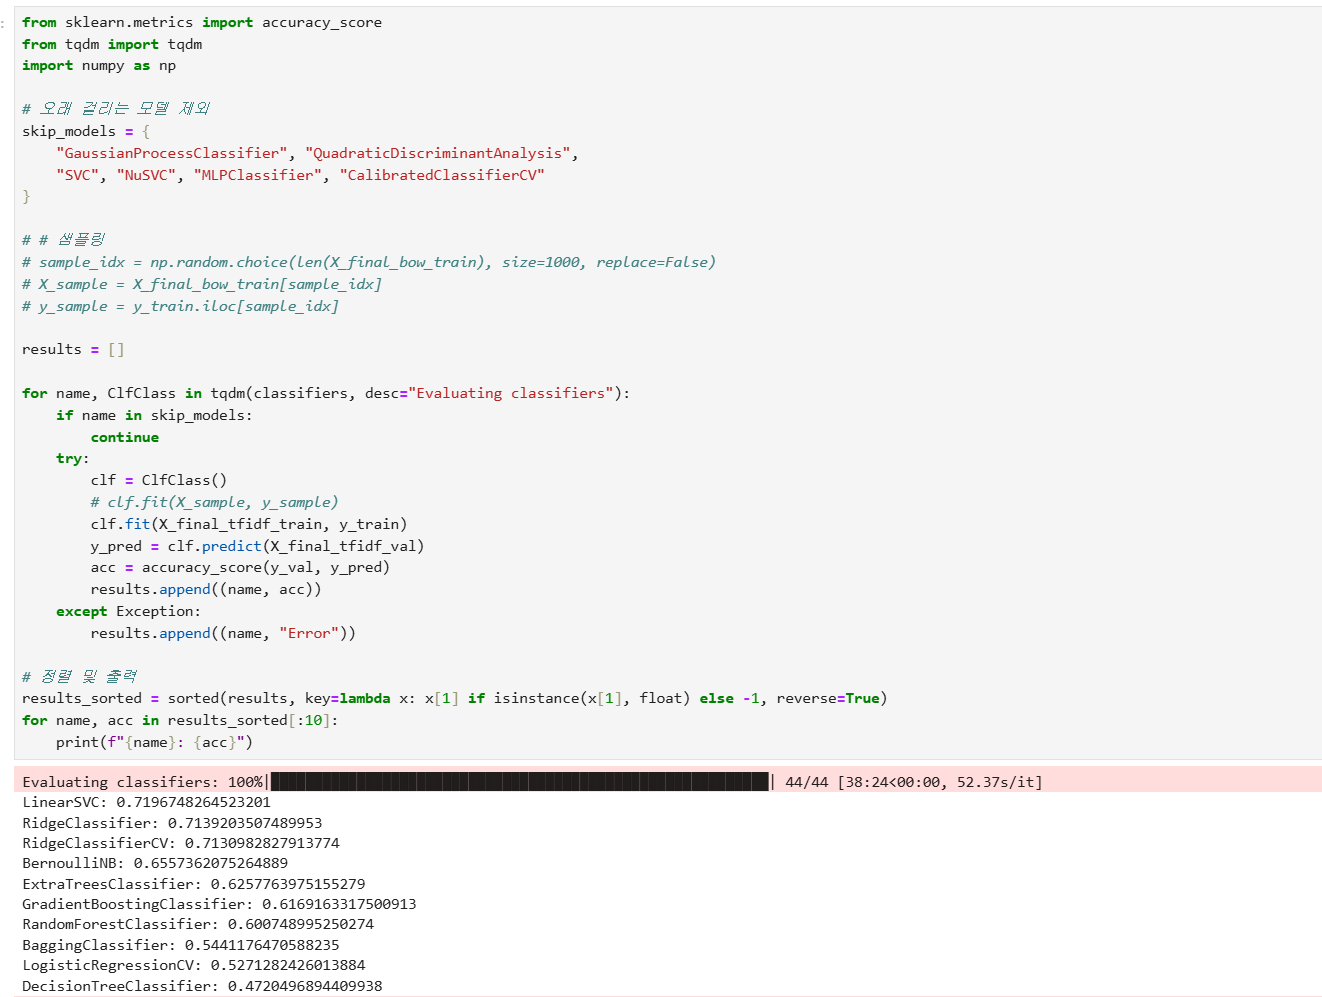

In [ ]:
# from sklearn.metrics import accuracy_score
# from tqdm import tqdm
# import numpy as np

# # 오래 걸리는 모델 제외
# skip_models = {
#     "GaussianProcessClassifier", "QuadraticDiscriminantAnalysis",
#     "SVC", "NuSVC", "MLPClassifier", "CalibratedClassifierCV"
# }

# from scipy.sparse import csr_matrix

# # COO -> CSR 변환
# X_final_tfidf_train = X_final_tfidf_train.tocsr()

# # 샘플링
# sample_idx = np.random.choice(X_final_tfidf_train.shape[0], size=1000, replace=False)
# X_sample = X_final_tfidf_train[sample_idx]
# y_sample = y_train.iloc[sample_idx]

# results = []

# for name, ClfClass in tqdm(classifiers, desc="Evaluating classifiers"):
#     if name in skip_models:
#         continue
#     try:
#         clf = ClfClass()
#         clf.fit(X_sample, y_sample)
#         clf.fit(X_final_tfidf_train, y_train)
#         y_pred = clf.predict(X_final_tfidf_val)
#         acc = accuracy_score(y_val, y_pred)
#         results.append((name, acc))
#     except Exception:
#         results.append((name, "Error"))

# # 정렬 및 출력
# results_sorted = sorted(results, key=lambda x: x[1] if isinstance(x[1], float) else -1, reverse=True)
# for name, acc in results_sorted[:10]:
#     print(f"{name}: {acc}")

### 모델링

In [ ]:
test.head()

,index,text,text_length,num_words,mean_word_len,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,...,contraction_count,length,tokens,stems,_filtered_tokens,num_stems,num_tokens,stopword_ratio,stemmed_tokens,lemmatized_tokens
0,0,“not at all. i think she is one of the most ch...,456,89,4.134831,68,456,57,9,0.056180,...,0,456,"['“', 'not', 'at', 'all', '.', 'i', 'think', '...","['think', 'charm', 'young', 'ladi', 'met', 'us...","['think', 'charming', 'young', 'ladies', 'met'...",32,89,0.640449,"['think', 'charm', 'young', 'ladi', 'met', 'us...","['think', 'charm', 'young', 'lady', 'meet', 'u..."
1,1,"""no,"" replied he, with sudden consciousness, ""...",221,43,4.162791,36,221,36,20,0.116279,...,0,221,"['``', 'no', ',', ""''"", 'replied', 'he', ',', ...","['repli', 'sudden', 'conscious', 'ignor', 'goo...","['replied', 'sudden', 'consciousness', 'ignora...",10,46,0.782609,"['repli', 'sudden', 'conscious', 'ignor', 'goo...","['reply', 'sudden', 'consciousness', 'ignorant..."
2,2,as the lady had stated her intention of scream...,375,64,4.875000,55,375,35,10,0.000000,...,0,375,"['as', 'the', 'lady', 'had', 'stated', 'her', ...","['ladi', 'state', 'intent', 'scream', 'cours',...","['lady', 'stated', 'intention', 'screaming', '...",28,63,0.555556,"['ladi', 'state', 'intent', 'scream', 'cours',...","['lady', 'state', 'intention', 'scream', 'cour..."
3,3,“and then suddenly in the silence i heard a so...,1218,240,4.079167,150,1218,148,28,0.045833,...,0,1218,"['“', 'and', 'then', 'suddenly', 'in', 'the', ...","['sudden', 'silenc', 'heard', 'sound', 'sent',...","['suddenly', 'silence', 'heard', 'sound', 'sen...",92,240,0.616667,"['suddenli', 'silenc', 'heard', 'sound', 'sent...","['suddenly', 'silence', 'heard', 'sound', 'sen..."
4,4,his conviction remained unchanged. so far as i...,510,91,4.615385,71,510,58,13,0.043956,...,0,510,"['his', 'conviction', 'remained', 'unchanged',...","['convict', 'remain', 'unchang', 'far', 'know'...","['conviction', 'remained', 'unchanged', 'far',...",35,93,0.623656,"['convict', 'remain', 'unchang', 'far', 'know'...","['conviction', 'remain', 'unchanged', 'far', '..."


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# 데이터 복사 (원본 보호)
X_train_copy = X_final_tfidf_train.copy()
y_train_copy = y_train.copy()
X_val_copy = X_final_tfidf_val.copy()
y_val_copy = y_val.copy()
test_copy = X_final_tfidf_test.copy()

# 1. 하이퍼파라미터 그리드 정의
param_grids = {
    'LinearSVC': {
        'C': [0.1, 1, 10],
        'max_iter': [1000, 2000]
    },
    'RidgeClassifier': {
        'alpha': [0.5, 1.0, 2.0]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

# 2. 모델 정의
models = {
    'LinearSVC': LinearSVC(random_state=42),
    'RidgeClassifier': RidgeClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# 3. GridSearchCV로 최적 모델 탐색
best_model = None
best_score = 0
best_model_name = ''
best_gs = None

for name in ['LinearSVC', 'RidgeClassifier', 'GradientBoosting']:
    print(f"\n🔍 GridSearchCV for {name}")
    model = models[name]
    param_grid = param_grids[name]

    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_copy, y_train_copy)

    print(f"Best {name} Params: {grid.best_params_}")
    print(f"{name} Best CV Score: {grid.best_score_:.4f}")

    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_model_name = name
        best_gs = grid

print(f"\n✅ Best Model: {best_model_name} with CV Accuracy: {best_score:.4f}")

# 4. Validation 데이터로 평가
val_preds = best_model.predict(X_val_copy)
val_acc = accuracy_score(y_val_copy, val_preds)
print(f"📊 Validation Accuracy on val set: {val_acc:.4f}")

# 5. test 데이터로 최종 예측
test_preds = best_model.predict(test_copy)


🔍 GridSearchCV for LinearSVC
Best LinearSVC Params: {'C': 0.1, 'max_iter': 1000}
LinearSVC Best CV Score: 0.7055

🔍 GridSearchCV for RidgeClassifier
Best RidgeClassifier Params: {'alpha': 2.0}
RidgeClassifier Best CV Score: 0.7057

🔍 GridSearchCV for GradientBoosting


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 데이터 복사 (원본 보호)
X_train_copy = X_final_tfidf_train.copy()
y_train_copy = y_train.copy()
X_val_copy = X_final_tfidf_val.copy()
y_val_copy = y_val.copy()
test_copy = X_final_tfidf_test.copy()

# GradientBoostingClassifier 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# 모델 정의
model = GradientBoostingClassifier(random_state=42)

# GridSearchCV 수행
grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_copy, y_train_copy)

# 최적 모델 및 결과 출력
best_model = grid.best_estimator_
print(f"\n✅ Best GradientBoosting Params: {grid.best_params_}")
print(f"📊 Best CV Accuracy: {grid.best_score_:.4f}")

# Validation 데이터로 성능 평가
val_preds = best_model.predict(X_val_copy)
val_acc = accuracy_score(y_val_copy, val_preds)
print(f"📊 Validation Accuracy on val set: {val_acc:.4f}")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 데이터 복사 (원본 보호)
X_train_copy = X_final_tfidf_train.copy()
y_train_copy = y_train.copy()
X_val_copy = X_final_tfidf_val.copy()
y_val_copy = y_val.copy()
test_copy = X_final_tfidf_test.copy()

# GradientBoostingClassifier 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# 모델 정의
model = GradientBoostingClassifier(random_state=42)

# GridSearchCV 수행
grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_copy, y_train_copy)

# 최적 모델 및 결과 출력
best_model = grid.best_estimator_
print(f"\n✅ Best GradientBoosting Params: {grid.best_params_}")
print(f"📊 Best CV Accuracy: {grid.best_score_:.4f}")


✅ Best GradientBoosting Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
📊 Best CV Accuracy: 0.6657


-> 가장 성능이 높은 RidgeClassifier을 best_params 2.0으로 설정해 모델링

In [ ]:
import ast
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

# === test 데이터 전처리 ===
test_copy = test.copy()

# 토큰 문자열 → 리스트로 변환
test_copy['_filtered_tokens'] = test_copy['_filtered_tokens'].apply(ast.literal_eval)
test_copy['lemmatized_tokens'] = test_copy['lemmatized_tokens'].apply(ast.literal_eval)
test_copy['stemmed_tokens'] = test_copy['stemmed_tokens'].apply(ast.literal_eval)

# 문장 생성 (TF-IDF 입력용)
test_copy['doc_for_embedding'] = test_copy['lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))

# TF-IDF 임베딩 (train에서 fit된 tfidf 사용)
X_text_tfidf_test = tfidf.transform(test_copy['doc_for_embedding'])

# === numeric feature 처리 ===
numeric_feature_columns = [
    'index', 'text_length', 'num_words', 'mean_word_len', 'num_unique_words', 'num_chars',
    'num_stopwords', 'num_punctuations', 'num_words_upper', 'num_words_title',
    'chars_between_comma', 'symbols_unknowns', 'noun', 'adj', 'verbs',
    'sentiment', 'single_frac', 'plural_frac', 'first_word_len', 'last_word_len',
    'first_word_id', 'last_word_id', 'ease', 'num_commas', 'count_The',
    'count_exclam', 'num_sentences', 'mean_sentence_len', 'ttr', 'rare_word_count',
    'rare_word_ratio', 'repetition_rate', 'num_questions', 'num_quotes',
    'contraction_count', 'length', 'num_stems', 'num_tokens', 'stopword_ratio'
]

# 스케일링을 위한 컬럼 (index 포함)
X_test_numeric_with_index = test_copy[numeric_feature_columns]
X_test_scaled_with_index = scaler.transform(X_test_numeric_with_index)  # index 포함 상태로 transform

# 모델 입력에서는 index 제거
index_pos = numeric_feature_columns.index('index')
X_test_scaled = np.delete(X_test_scaled_with_index, index_pos, axis=1)  # numpy에서 index 열 제거

# TF-IDF 희소 행렬 + 스케일된 numeric feature 결합
X_final_tfidf_test = hstack([X_text_tfidf_test, X_test_scaled])

print("✅ TF-IDF + numeric features (test) shape:", X_final_tfidf_test.shape)

# === 모델 학습 및 검증 ===
X_train_copy = X_final_tfidf_train.copy()
y_train_copy = y_train.copy()
X_val_copy = X_final_tfidf_val.copy()
y_val_copy = y_val.copy()

final_model = RidgeClassifier(alpha=2.0)
final_model.fit(X_train_copy, y_train_copy)

val_preds = final_model.predict(X_val_copy)
val_accuracy = accuracy_score(y_val_copy, val_preds)
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")

# === 테스트 데이터 예측 ===
test_preds = final_model.predict(X_final_tfidf_test)

✅ TF-IDF + numeric features (test) shape: (19606, 5038)
✅ Validation Accuracy: 0.7177


In [ ]:
# submission_copy는 이미 존재하는 DataFrame이라고 가정 (index와 0~4 열 포함)

# 모든 값을 0으로 초기화 (혹시 이전 값이 있을 경우 대비)
submission_copy = submission.copy()
submission_copy.iloc[:, 1:] = 0  # 첫 번째 열은 index라고 가정하고 제외

# 예측값을 기반으로 해당 위치에 1 할당
for i, pred in enumerate(test_preds):
    submission_copy.iat[i, pred + 1] = 1  # +1은 'index' 열 다음부터 클래스 열이기 때문

# CSV 파일로 저장
submission_copy.to_csv("submission_final.csv", index=False)
print("✅ submission_final.csv 파일 저장 완료")


✅ submission_final.csv 파일 저장 완료


- 최종 결과:
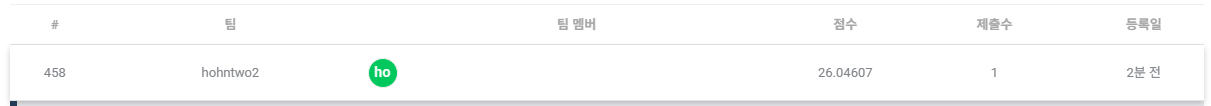

# BERT 코드

In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 첫 번째 GPU만 사용
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from transformers import TFDistilBertModel, DistilBertTokenizer

# 기존 모델보다 경량화된 모델(DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

(흐름)

라이브러리 및 경로 설정 -> BERT Tokenizer 로드 -> 텍스트를 BERT 형식으로 인코딩 -> BERT 분류기 모델 정의 -> Stratified K-Fold로 교차 검증 학습 -> 최종 평가

“보통은 임베딩한 다음에 LSTM이나 CNN 같은 걸 써서 모델링(예: 문맥 파악, 분류 등)을 하는데, BERT는 임베딩하고 나서 뭘로 모델링을 하는지?”

-> BERT는 LSTM이나 CNN 없이 자체적으로 “Transformer Encoder” 구조만으로 문맥을 이해하고 모델링까지 끝냄.
즉, 추가적인 모델링이 필요 없이, 이미 BERT 내부에서 문맥을 깊게 이해함



bert_encode 함수 : BERT 모델에 텍스트 데이터를 입력 가능한 형태로 변환(전처리) 해주는 함수

distilbert-base-cased 쓸 때는 segment_ids가 필요 없음

In [ ]:
def distilbert_encode(texts, tokenizer, max_len=100):
    all_tokens = []
    all_masks = []

    for text in texts:
        tokens = tokenizer.tokenize(text)
        tokens = tokens[:max_len - 2]
        input_sequence = ['[CLS]'] + tokens + ['[SEP]']

        input_ids = tokenizer.convert_tokens_to_ids(input_sequence)

        pad_len = max_len - len(input_ids)
        input_ids += [0] * pad_len
        attention_mask = [1] * len(input_sequence) + [0] * pad_len
        attention_mask = attention_mask[:max_len]

        all_tokens.append(input_ids)
        all_masks.append(attention_mask)

    return np.array(all_tokens), np.array(all_masks)

- trn : 학습 데이터(train) 를 BERT 모델 입력용으로 인코딩한 결과

- tst : 테스트 데이터(test) 를 BERT 모델 입력용으로 인코딩한 결과

In [ ]:
max_len = 128 # 보통 기본값이 128이라고 함

trn = distilbert_encode(train.text.values, tokenizer, max_len=max_len)
tst = distilbert_encode(test.text.values, tokenizer, max_len=max_len)
y = train['author'].values
print(trn[0].shape, tst[0].shape, y.shape)

(54879, 128) (19617, 128) (54879,)


- input_word_ids: 단어를 숫자로 바꾼 것 (BERT가 이해할 수 있는 형태)

- input_mask: 문장의 진짜 내용은 1, 패딩은 0 (BERT가 어디까지 읽어야 할지 알려줌)

- segment_ids: 문장 A/B 구분용

In [ ]:
# BERT 모델을 기반으로 텍스트 분류기(classifier)를 만드는 함수(문장을 넣으면 어느 작가의 글인지 예측)

from transformers import TFDistilBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

n_class = train['author'].nunique()
max_len = 128

bert_layer = TFDistilBertModel.from_pretrained('distilbert-base-cased')

def get_model(bert_layer, max_len=max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    # segment_ids 제거

    def bert_fn(inputs):
        return bert_layer(
            input_ids=inputs[0],
            attention_mask=inputs[1]
            # token_type_ids 제거
        ).last_hidden_state[:, 0, :]  # DistilBERT는 pooler_output 없으므로 [CLS] 토큰 출력 사용

    # output_shape는 hidden_size=768
    bert_output = Lambda(bert_fn, output_shape=(768,))([input_word_ids, input_mask])

    x = Dense(256, activation='relu')(bert_output)
    out = Dense(n_class, activation='softmax')(x)

    model = Model(inputs=[input_word_ids, input_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


BERT 모델을 사용해서 교차검정으로 학습하고, 검증 예측값과 테스트 예측값을 만드는 코드

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
import gc
import numpy as np
import tensorflow as tf

# y: 정답 레이블 배열, n_class: 클래스 수
p_val = np.zeros((trn[0].shape[0], n_class))
p_tst = np.zeros((tst[0].shape[0], n_class))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (i_trn, i_val) in enumerate(cv.split(trn[0], y), 1):
    print(f'training model for CV #{i}')

    es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2,
                       verbose=1, mode='max', restore_best_weights=True)

    clf = get_model(bert_layer, max_len=max_len)

    if i == 1:
        print(clf.summary())

    clf.fit(
        x={
            "input_word_ids": trn[0][i_trn],
            "input_mask": trn[1][i_trn],
            # "segment_ids": trn[2][i_trn],  # 제거됨
        },
        y=tf.keras.utils.to_categorical(y[i_trn], num_classes=n_class),
        validation_data=(
            {
                "input_word_ids": trn[0][i_val],
                "input_mask": trn[1][i_val],
                # "segment_ids": trn[2][i_val],  # 제거됨
            },
            tf.keras.utils.to_categorical(y[i_val], num_classes=n_class)
        ),
        epochs=5,
        batch_size=8,
        callbacks=[es]
    )

    p_val[i_val, :] = clf.predict({
        "input_word_ids": trn[0][i_val],
        "input_mask": trn[1][i_val],
        # "segment_ids": trn[2][i_val],  # 제거됨
    })

    p_tst += clf.predict({
        "input_word_ids": tst[0],
        "input_mask": tst[1],
        # "segment_ids": tst[2],  # 제거됨
    }) / 5

    del clf
    clear_session()
    gc.collect()

training model for CV #1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_word_ids      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mask          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 768)       │          0 │ input_word_ids[0… │
│                     │                   │            │ input_mask[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    196,864 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      1,285 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 198,149 (774.02 KB)

 Trainable params: 198,149 (774.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5488/5488 ━━━━━━━━━━━━━━━━━━━━ 213s 36ms/step - accuracy: 0.3674 - loss: 1.4934 - val_accuracy: 0.5079 - val_loss: 1.3293
Epoch 2/5
5488/5488 ━━━━━━━━━━━━━━━━━━━━ 256s 36ms/step - accuracy: 0.5218 - loss: 1.2980 - val_accuracy: 0.5452 - val_loss: 1.2229
Epoch 3/5
5488/5488 ━━━━━━━━━━━━━━━━━━━━ 198s 35ms/step - accuracy: 0.5578 - loss: 1.2042 - val_accuracy: 0.5682 - val_loss: 1.1591
Epoch 4/5
5488/5488 ━━━━━━━━━━━━━━━━━━━━ 206s 36ms/step - accuracy: 0.5757 - loss: 1.1410 - val_accuracy: 0.5766 - val_loss: 1.1162
Epoch 5/5
5488/5488 ━━━━━━━━━━━━━━━━━━━━ 198s 35ms/step - accuracy: 0.5803 - loss: 1.1102 - val_accuracy: 0.5829 - val_loss: 1.0900
Restoring model weights from the end of the best epoch: 5.
343/343 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step
614/614 ━━━━━━━━━━━━━━━━━━━━ 72s 117ms/step
training model for CV #2
Epoch 1/5
5488/5488 ━━━━━━━━━━━━━━━━━━━━ 207s 36ms/step - accuracy: 0.3614 - loss: 1.5034 - val_accuracy: 0.5001 - val_loss: 1.3427
Epoch 2/5
5488/5488 ━━━━━━━━━━━

In [ ]:
print("p_val shape:", p_val.shape)
print("p_val example:", p_val[:5])  # 상위 5개 예시

print("p_tst shape:", p_tst.shape)
print("p_tst example:", p_tst[:5])

p_val shape: (54879, 5)
p_val example: [[0.26838517 0.08581326 0.0621579  0.4895691  0.09407455]
 [0.36759931 0.20266983 0.26075473 0.11877437 0.05020177]
 [0.17339836 0.61017108 0.02750226 0.15251797 0.03641032]
 [0.03385123 0.01858151 0.68744248 0.02026679 0.239858  ]
 [0.17829025 0.0908103  0.12333387 0.40029803 0.20726754]]
p_tst shape: (19617, 5)
p_tst example: [[0.05133381 0.52909616 0.13645914 0.26537599 0.0177349 ]
 [0.34871941 0.21313095 0.04291945 0.13302579 0.26220442]
 [0.30431745 0.23141384 0.03970382 0.17915035 0.24541455]
 [0.47693457 0.00631925 0.2130023  0.0322695  0.27147438]
 [0.23561693 0.15548439 0.24394381 0.20987855 0.15507632]]


- 런타임이 너무 길어서 파일 저장 -> 다음번에 안돌려도 결과 볼 수 있음

In [ ]:
np.savez("/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/개인코드/cv_outputs.npz", p_val=p_val, p_tst=p_tst)

In [ ]:
data = np.load("/content/drive/MyDrive/ESAA OB 3조/프로젝트(2)_소설작가 분류/개인코드/cv_outputs.npz")

p_val = data['p_val']
p_tst = data['p_tst']

In [ ]:
p_val

array([[0.26838517, 0.08581326, 0.0621579 , 0.4895691 , 0.09407455],
       [0.36759931, 0.20266983, 0.26075473, 0.11877437, 0.05020177],
       [0.17339836, 0.61017108, 0.02750226, 0.15251797, 0.03641032],
       ...,
       [0.23739587, 0.14608432, 0.17272593, 0.33530805, 0.1084858 ],
       [0.0955127 , 0.05704457, 0.33224535, 0.46993661, 0.04526073],
       [0.54253429, 0.12646683, 0.10506155, 0.17921004, 0.04672724]])

In [ ]:
p_tst

array([[0.05133381, 0.52909616, 0.13645914, 0.26537599, 0.0177349 ],
       [0.34871941, 0.21313095, 0.04291945, 0.13302579, 0.26220442],
       [0.30431745, 0.23141384, 0.03970382, 0.17915035, 0.24541455],
       ...,
       [0.26597466, 0.63801604, 0.01694618, 0.0232469 , 0.05581624],
       [0.19900554, 0.29008345, 0.21069049, 0.12643203, 0.1737885 ],
       [0.08788904, 0.06976763, 0.11905037, 0.59339549, 0.12989745]])

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd  # log_loss에 one-hot encoding이 필요해서 사용
import numpy as np

print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  58.5233%
Log Loss (CV):   1.0904


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
